In [ ]:
import pandas as pd
import numpy as np
import torch
import os
import sys
from tqdm import tqdm, trange

from sdv.single_table import CTGANSynthesizer

sys.path.append("../../")
import biked_commons
from biked_commons.design_evaluation.design_evaluation import *
from biked_commons.resource_utils import models_and_scalers_path
from biked_commons.data_loading import data_loading
from biked_commons.conditioning import conditioning
from biked_commons.design_evaluation.scoring import *
from biked_commons.transformation.one_hot_encoding import ONE_HOT_ENCODED_CLIPS_COLUMNS, BOOLEAN_COLUMNS, encode_to_continuous

We use the full dataset for synthetic data generation:

In [ ]:
data_train = data_loading.load_bike_bench_mixed_modality_train()
data_test = data_loading.load_bike_bench_mixed_modality_test()
data = pd.concat([data_train, data_test], axis=0)

In [ ]:
import sdv
from sdv.metadata import Metadata  
metadata = Metadata.detect_from_dataframe(
    data=data,
    table_name='my_table'
)

categorical_cols = ONE_HOT_ENCODED_CLIPS_COLUMNS
boolean_cols = BOOLEAN_COLUMNS
continuous_cols = data.columns.difference(categorical_cols + boolean_cols).tolist()


In [4]:
data[continuous_cols] = data[continuous_cols].astype(np.float32)

In [ ]:
for col in data.columns:
    if col not in categorical_cols and col not in boolean_cols:
        data[col] = data[col] + np.ones_like(data[col])
        #make float
        data[col] = data[col].astype(float)

In [ ]:
synthesizer = CTGANSynthesizer(metadata, verbose=True, epochs=500)
synthesizer.fit(data)

/home/mileva/mambaforge/envs/torch/lib/python3.12/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


KeyboardInterrupt: 

In [9]:
save_path = models_and_scalers_path("CTGAN.pkl")

In [ ]:
synthesizer.save(save_path)

In [10]:
synthesizer = CTGANSynthesizer.load(filepath=save_path)


In [11]:
synthetic_collapsed = synthesizer.sample(num_rows=10000)

In [12]:
synthetic_collapsed

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,FORK0R,...,RIM_STYLE rear,SPOKES composite front,SPOKES composite rear,SBLADEW front,SBLADEW rear,Saddle length,Saddle height,Down tube diameter,Seatpost LENGTH,Seat tube type
0,387.86868,67.139141,636.039823,73.719472,169.375422,40.76,520.39,73.589453,614.949524,12.78,...,DISC,1,1,80.3,80.1,276.4,697.4,34.965629,296.0,2
1,0.00000,36.841890,533.960641,73.751731,158.450533,29.65,363.48,70.263936,518.417255,44.77,...,SPOKED,3,1,79.8,79.9,275.3,810.3,48.058268,302.0,1
2,396.29711,74.881103,591.839087,79.160227,179.486925,46.36,546.86,77.064157,678.659230,30.65,...,SPOKED,1,1,79.9,80.1,276.3,723.4,35.515832,327.0,1
3,346.30826,44.050081,573.518707,75.751162,159.515366,45.61,503.58,80.797103,774.538409,44.11,...,SPOKED,1,1,79.7,79.7,298.3,814.2,34.766799,302.0,2
4,418.11679,73.365800,584.617676,69.181035,147.891381,44.67,465.64,73.522535,668.054997,30.93,...,SPOKED,1,1,79.7,79.6,279.5,711.1,34.748331,337.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,332.93582,9.565175,611.556747,75.316522,164.304941,-6.03,509.23,76.118940,656.147209,37.56,...,SPOKED,1,1,79.5,79.7,274.6,558.3,33.268829,302.0,1
9996,391.92362,72.974796,633.806446,74.763571,132.674772,48.69,622.86,76.075309,670.655474,54.48,...,SPOKED,1,1,80.2,79.7,301.3,840.1,34.637998,335.0,1
9997,393.33608,72.858908,669.676555,76.301934,235.291591,41.66,633.86,74.807785,623.411005,54.01,...,TRISPOKE,1,1,80.0,80.0,294.8,679.3,34.784533,325.0,2
9998,395.95615,71.743670,618.715411,73.285898,239.132685,91.01,576.04,75.286721,598.834768,45.74,...,DISC,1,1,79.8,79.7,300.5,672.6,34.649140,298.0,0


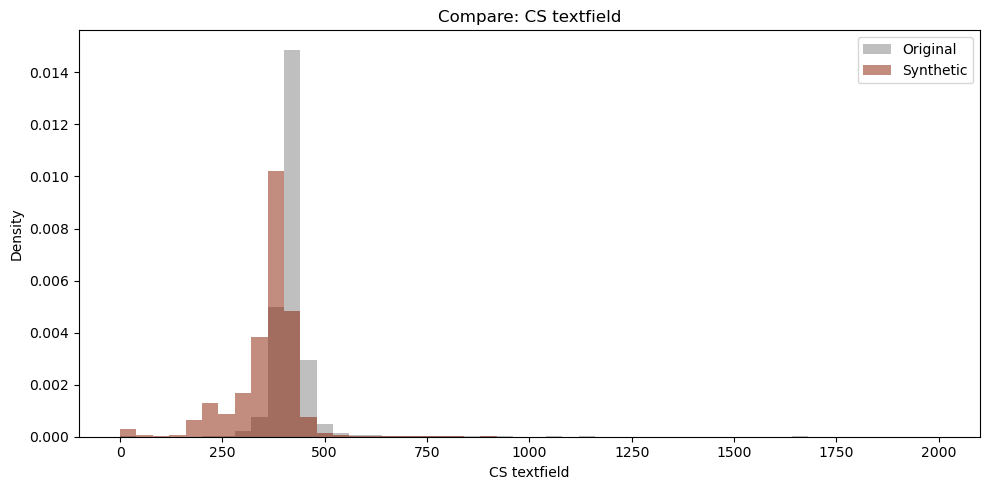

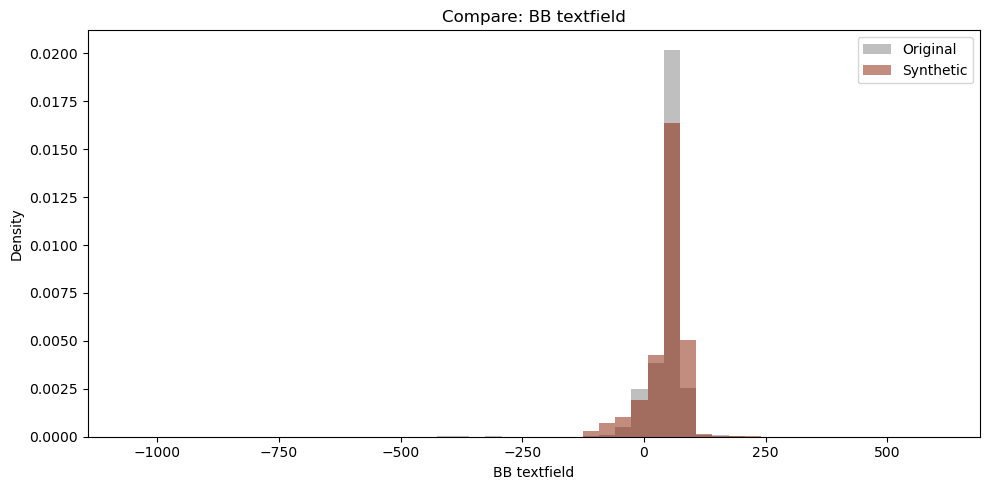

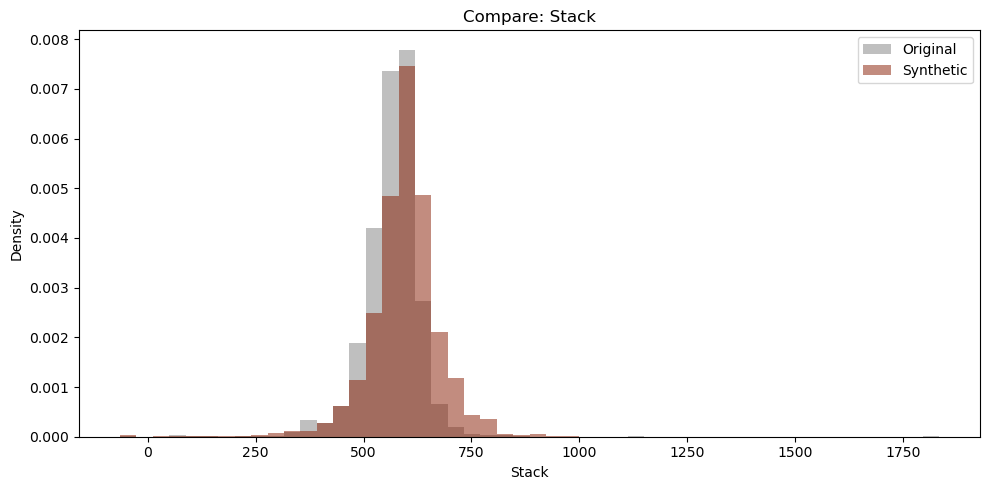

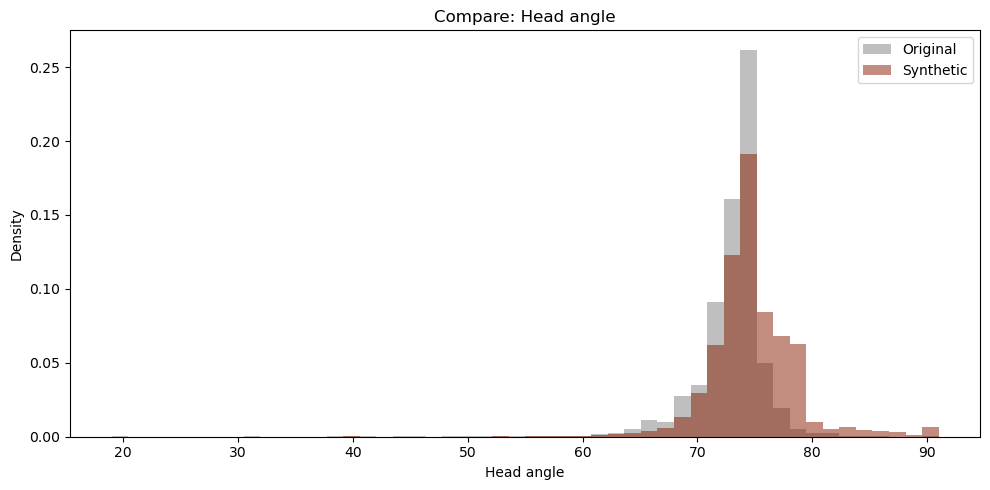

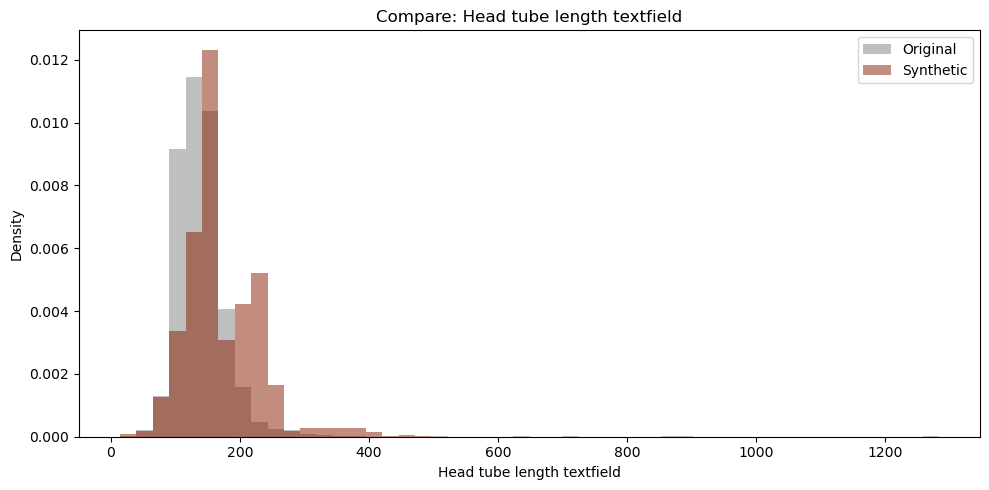

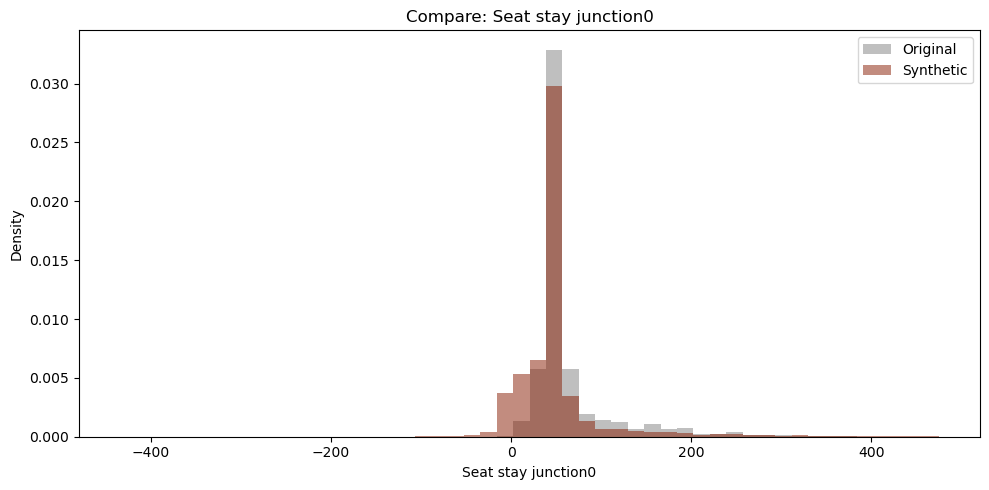

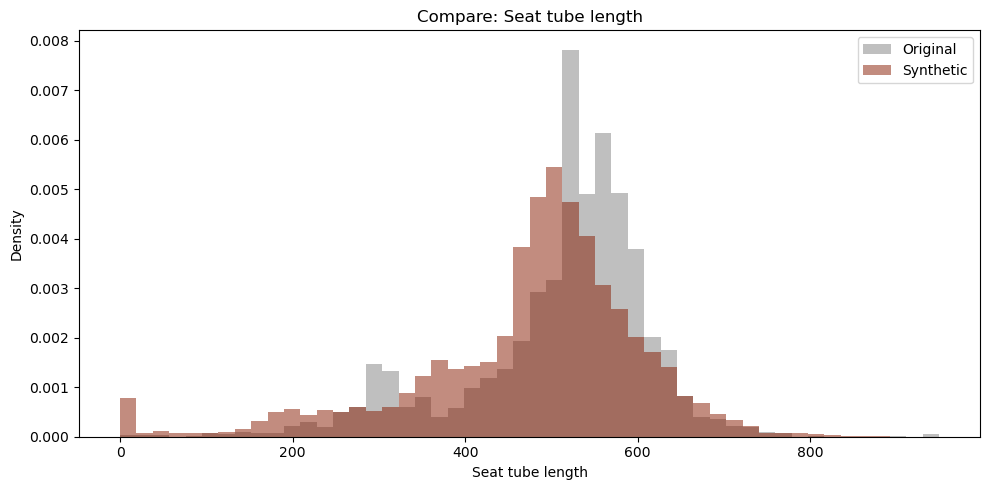

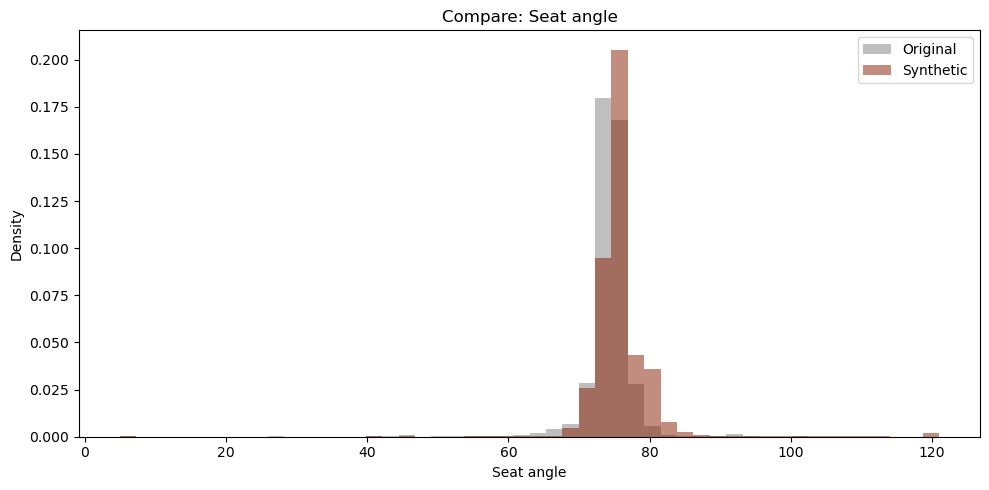

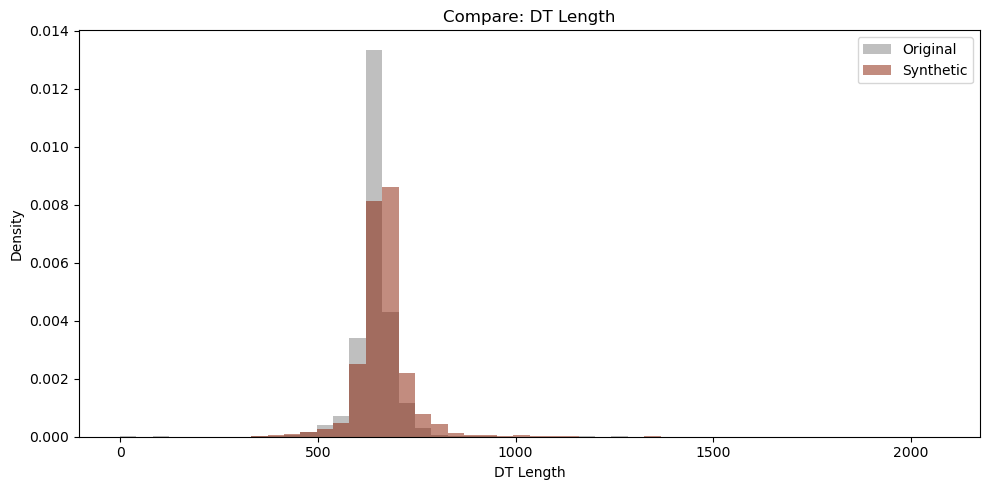

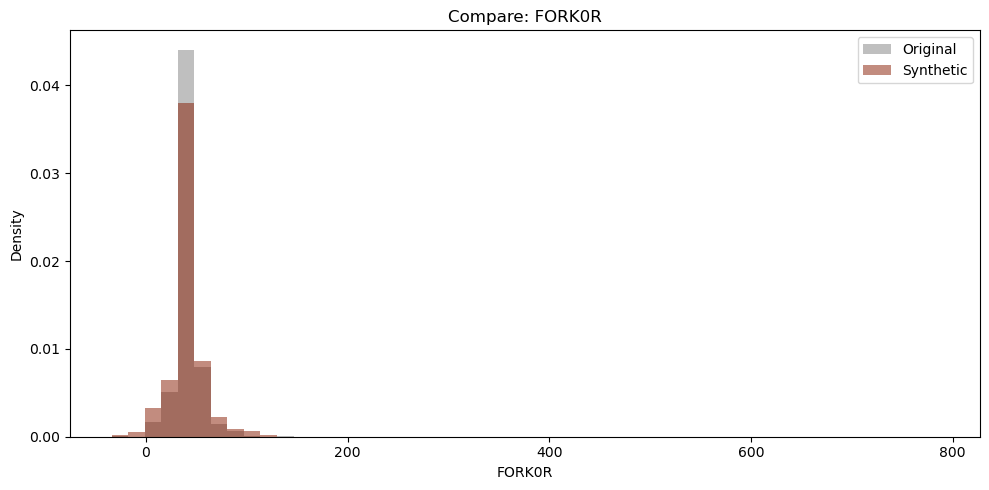

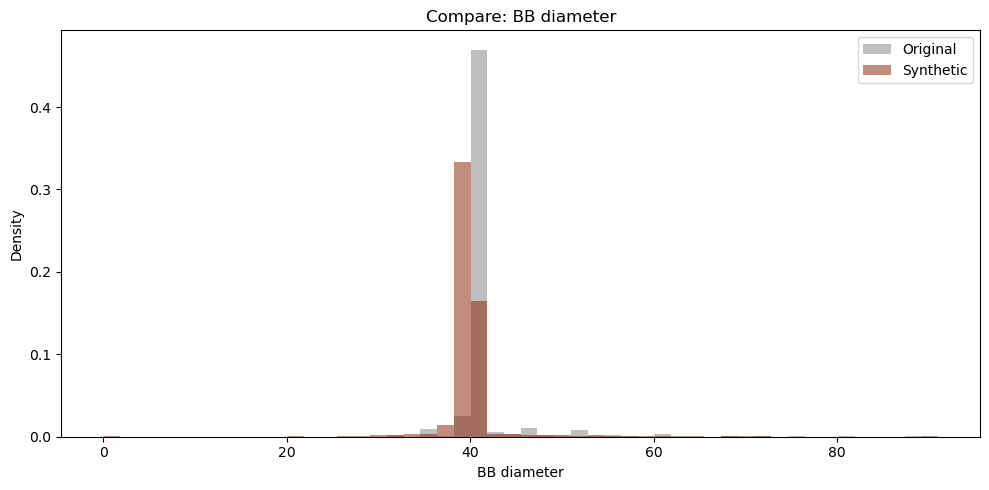

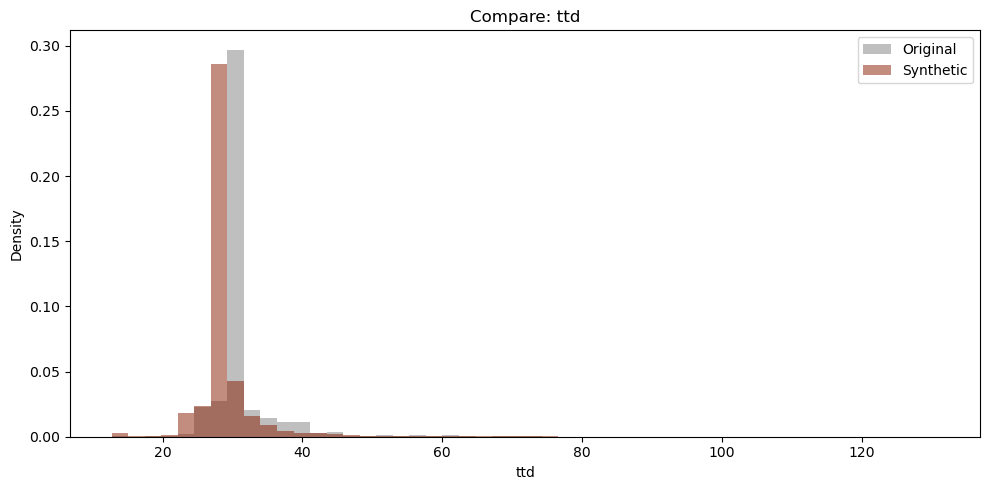

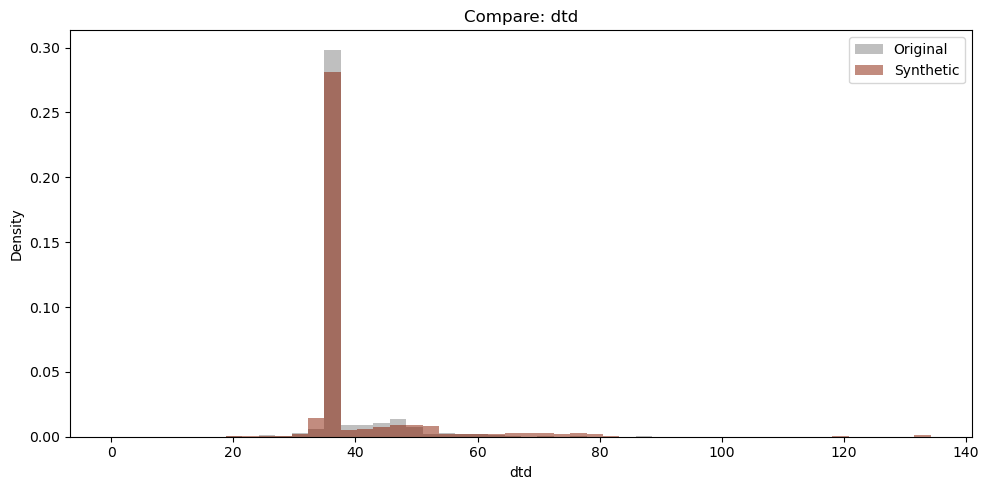

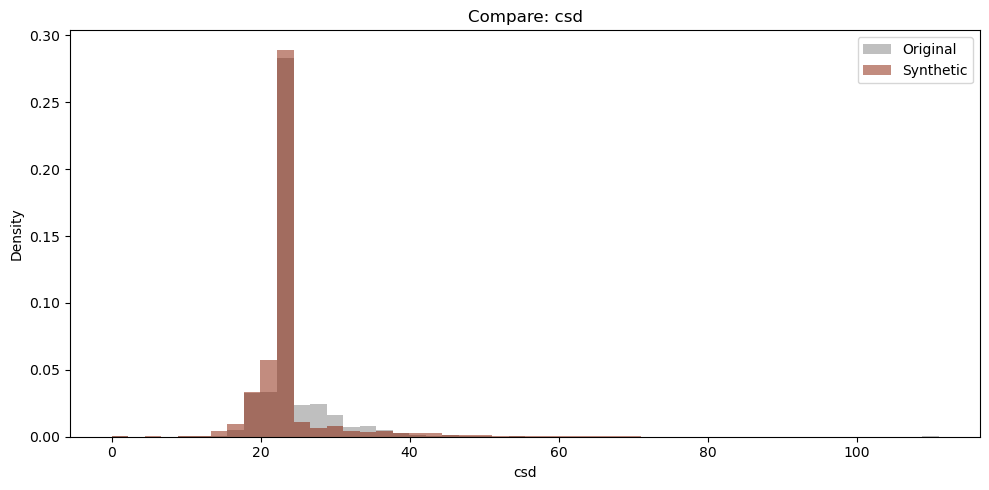

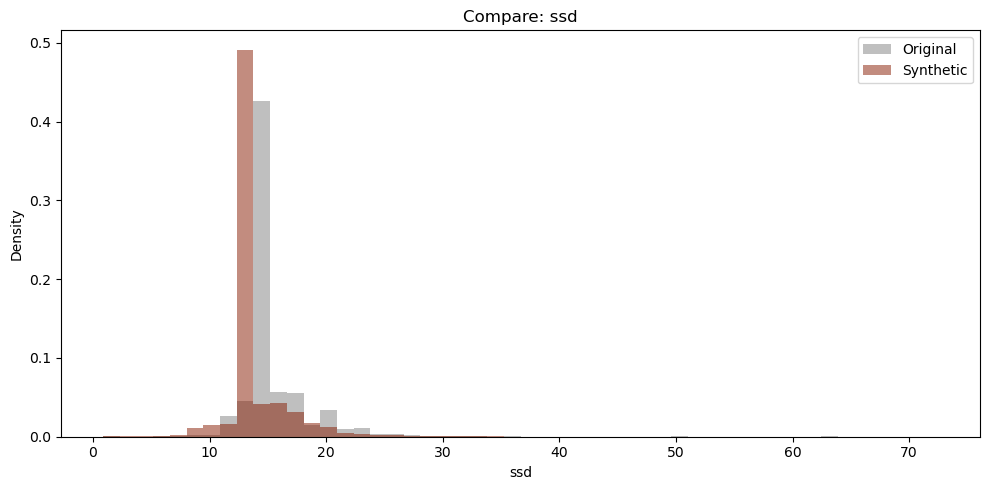

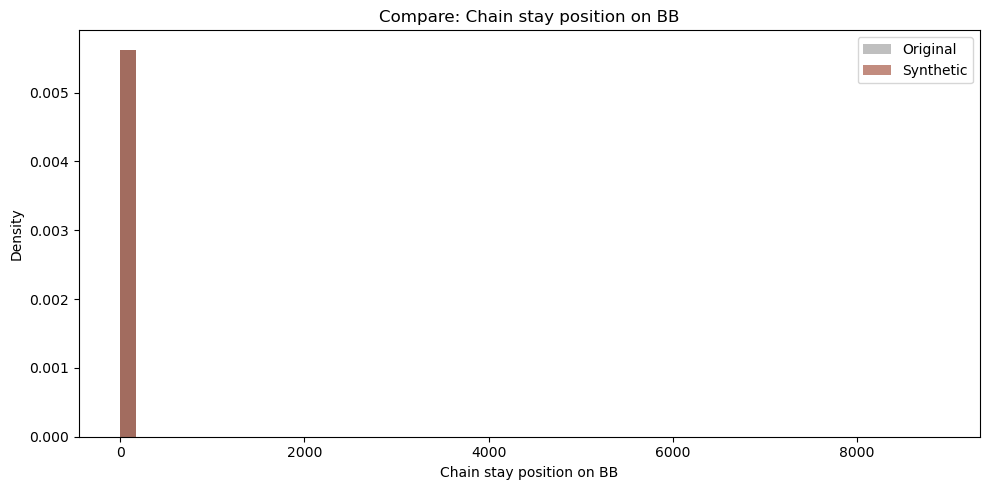

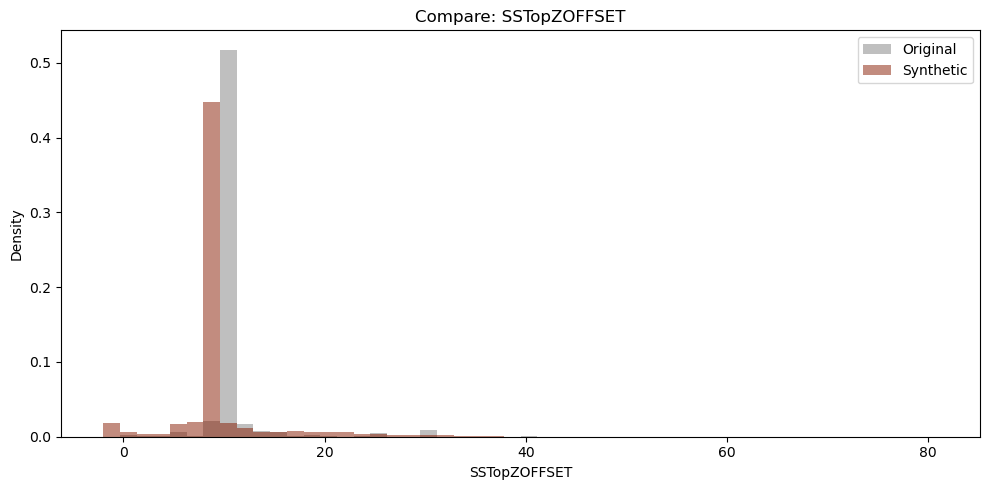

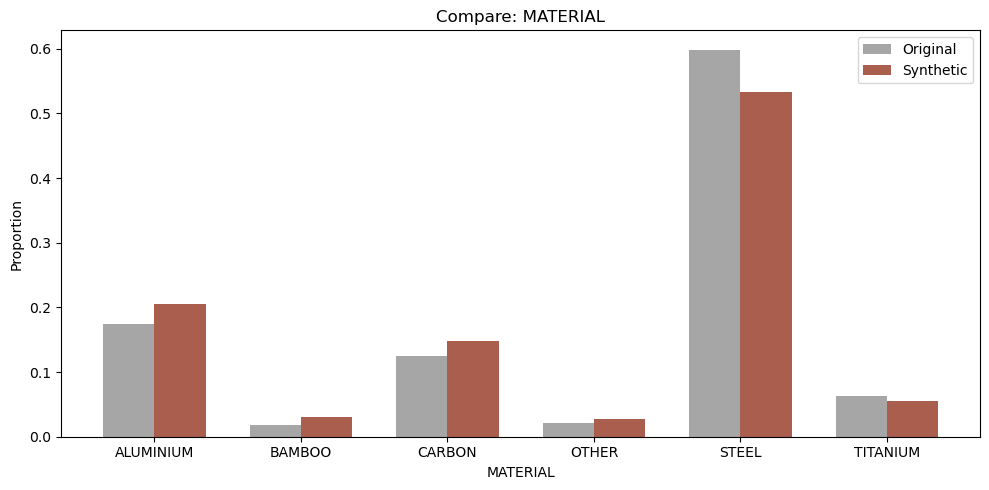

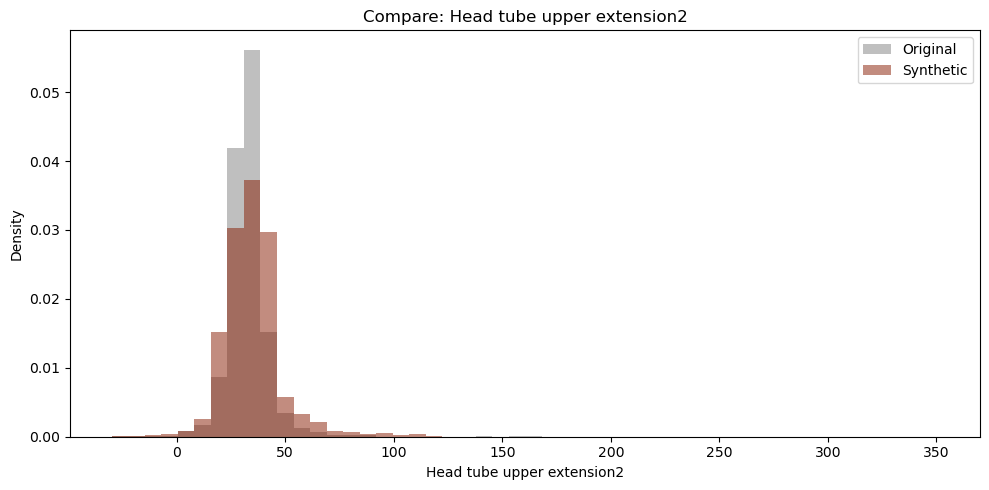

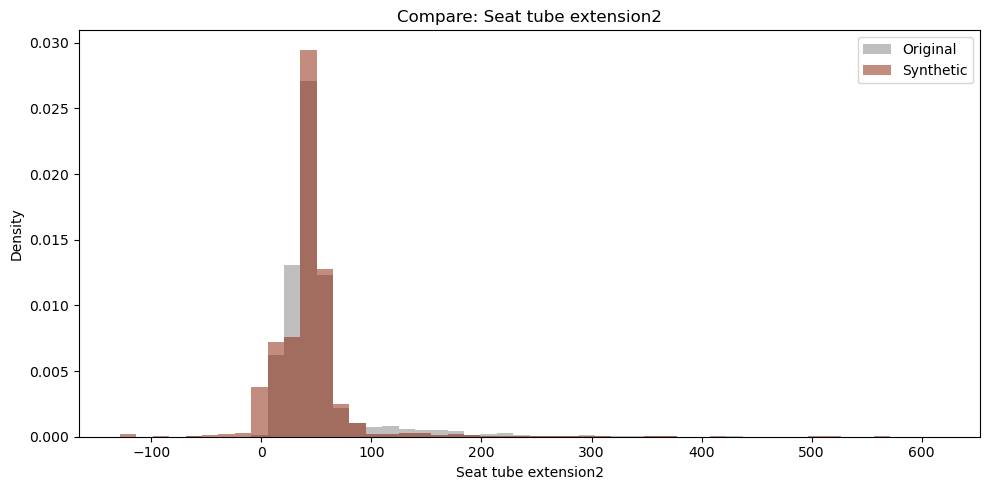

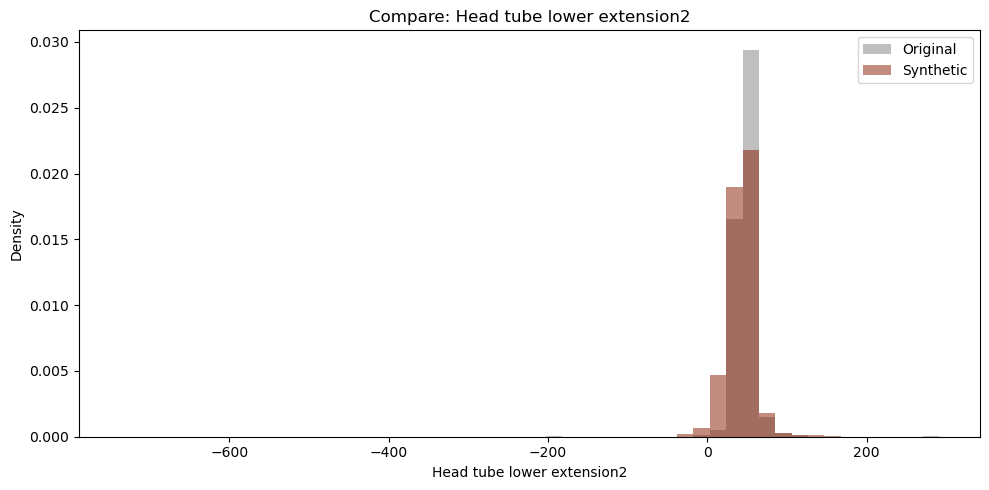

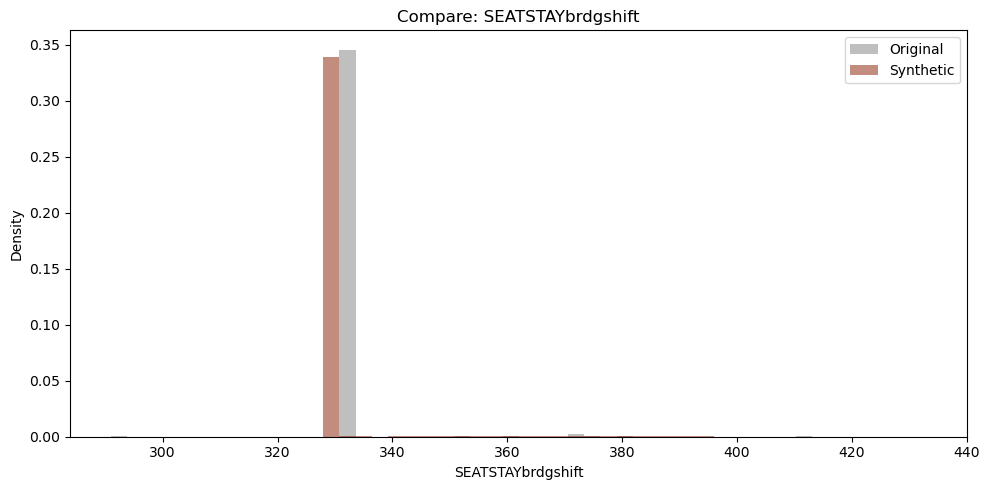

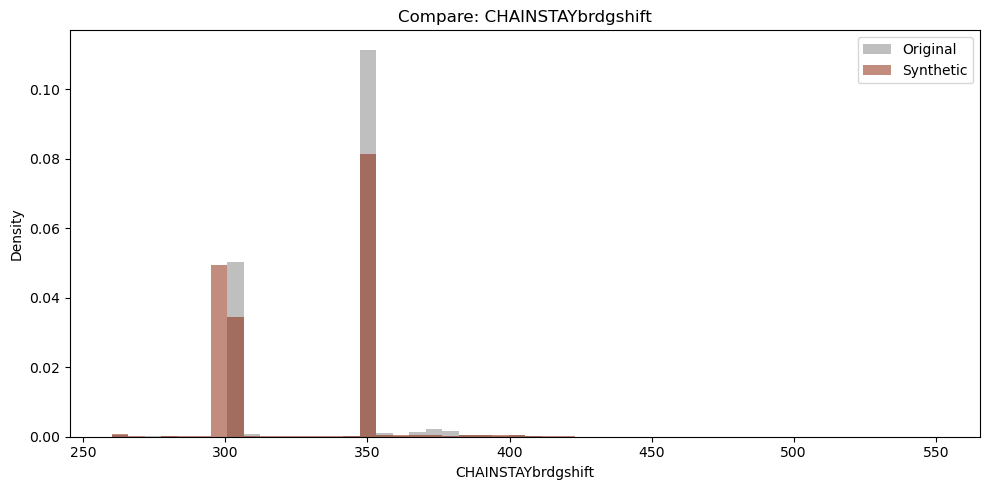

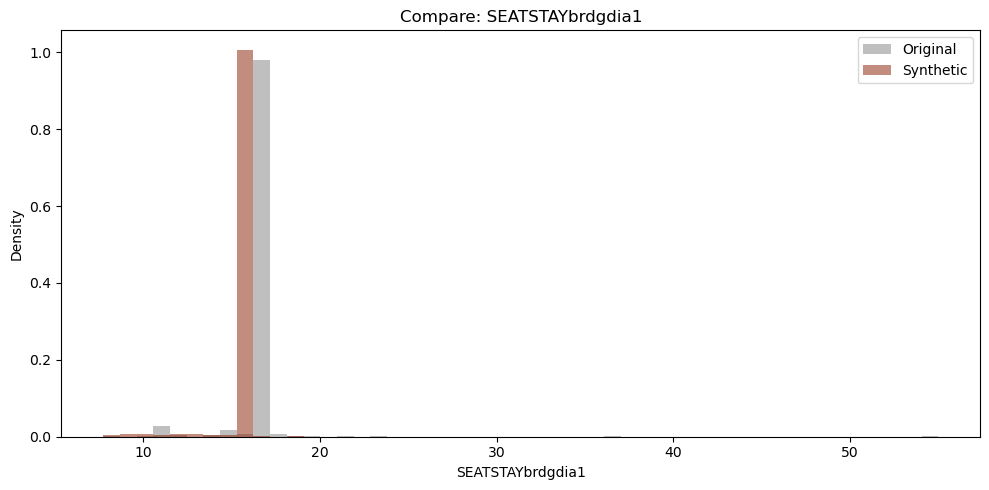

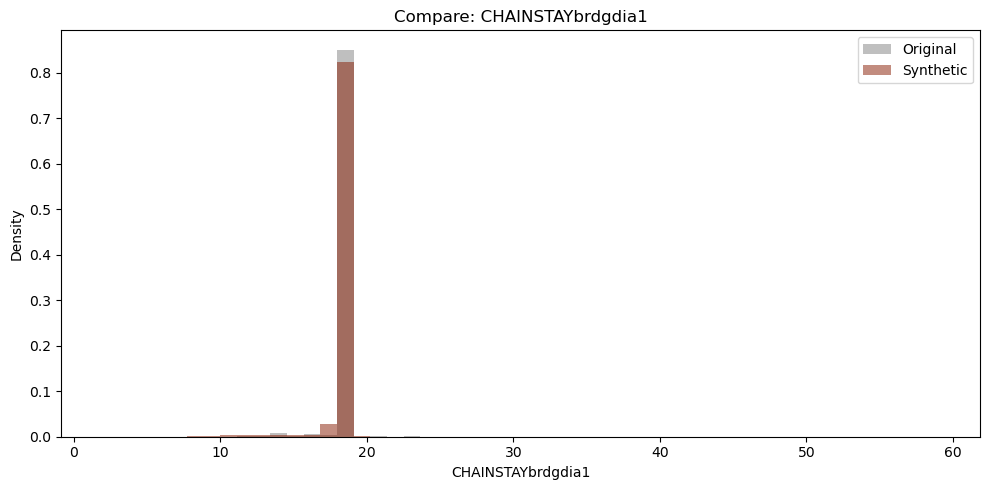

/home/mileva/mambaforge/envs/torch/lib/python3.12/site-packages/matplotlib/axes/_axes.py:7001: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


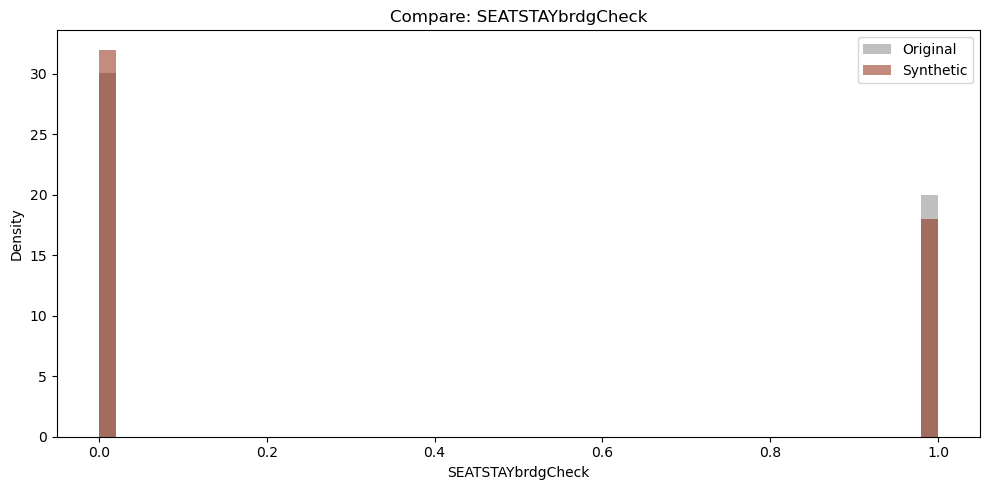

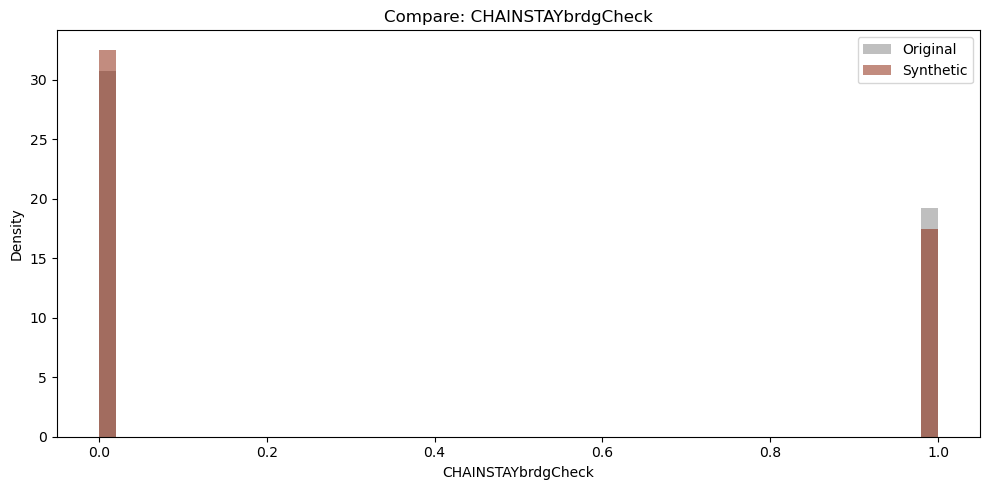

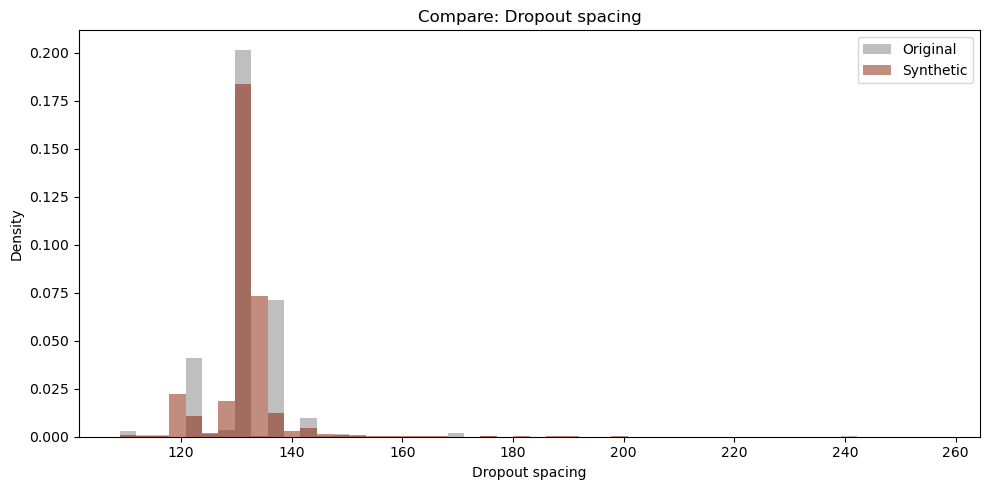

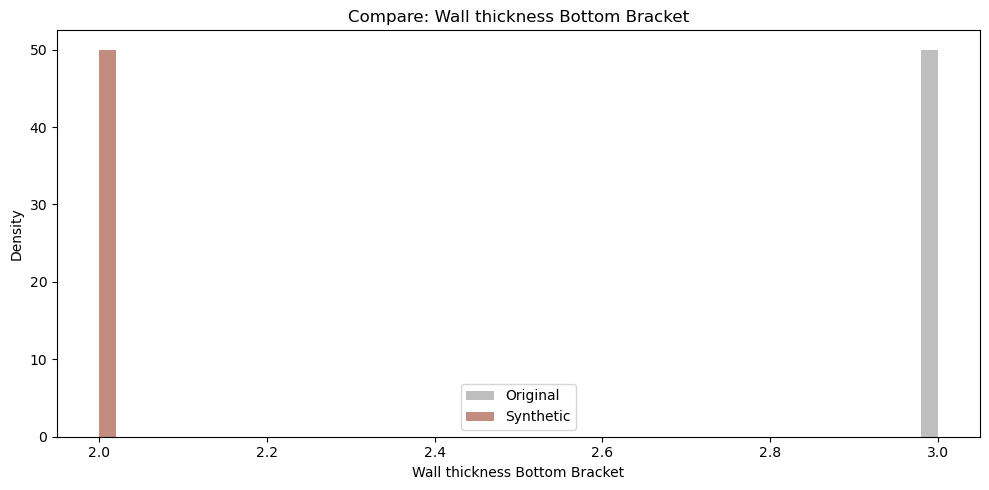

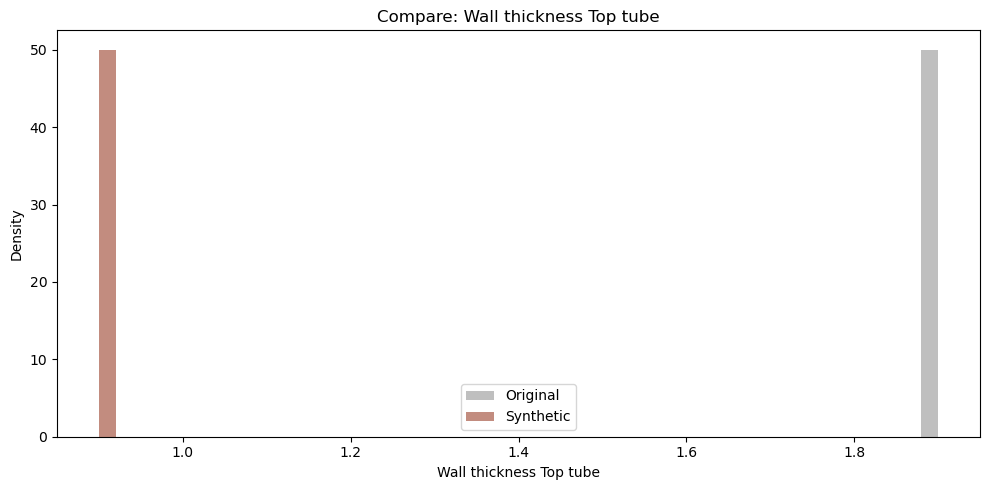

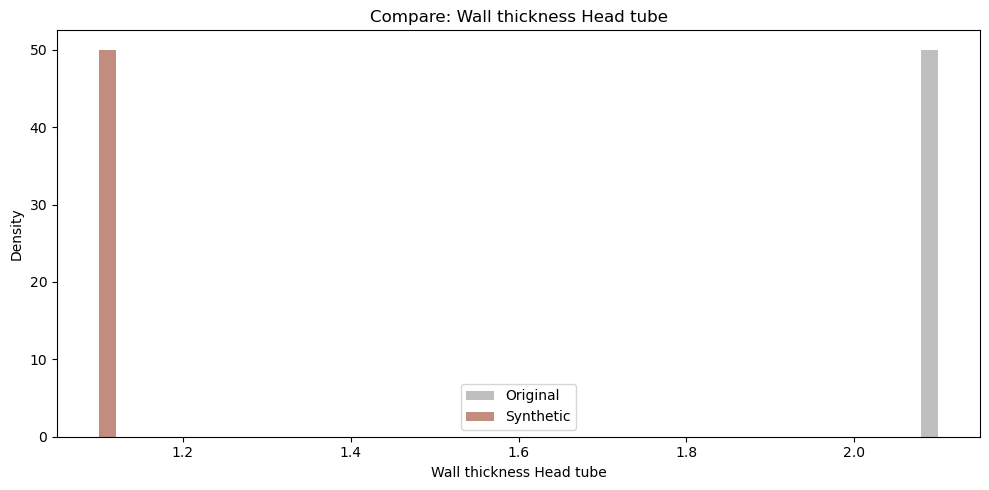

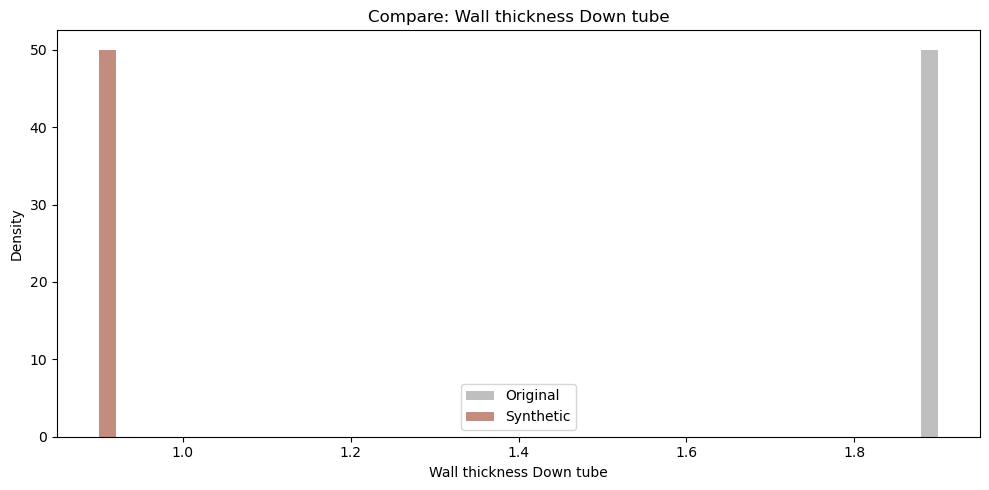

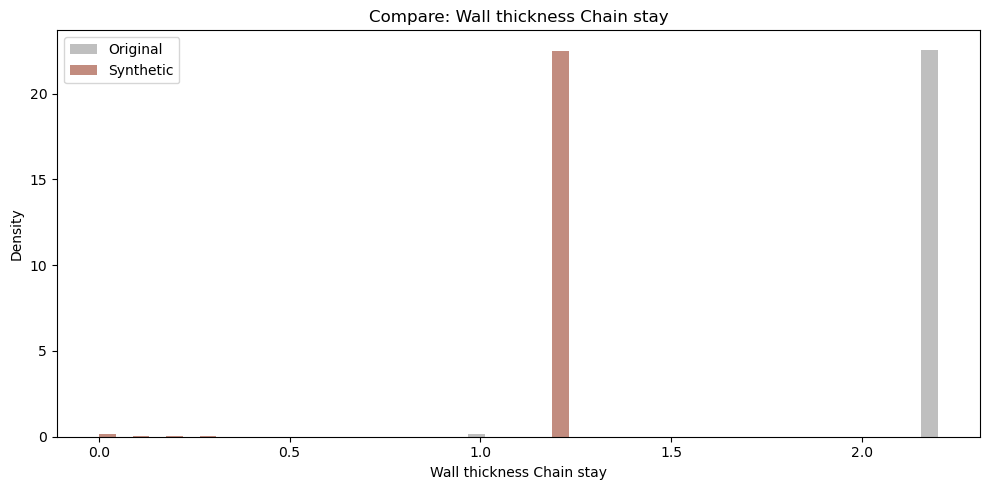

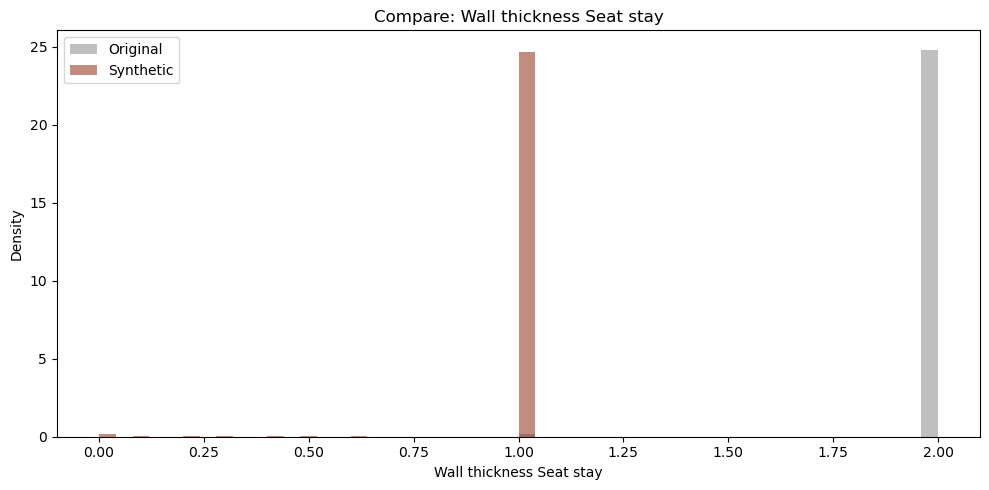

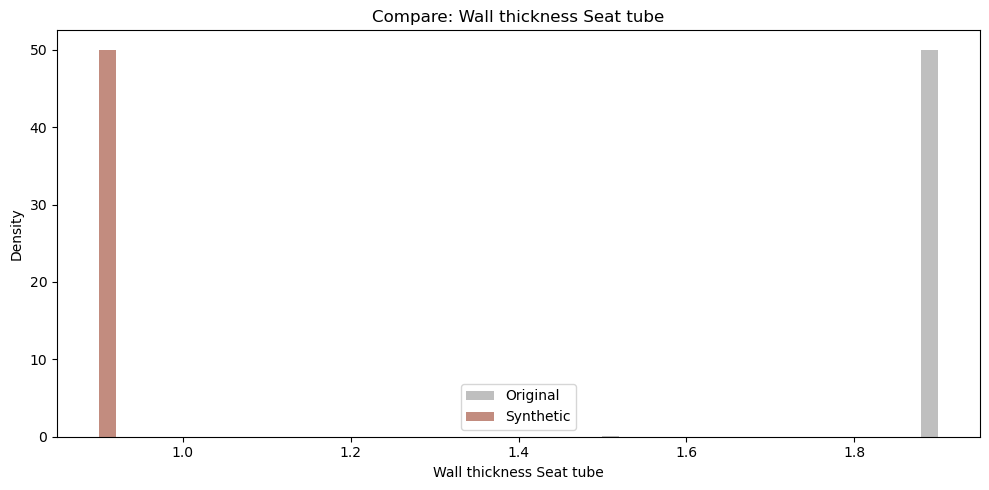

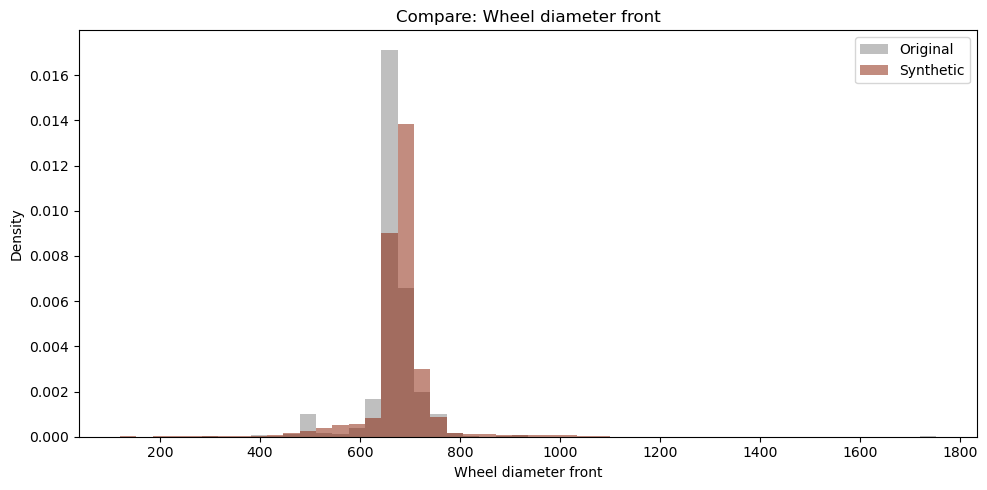

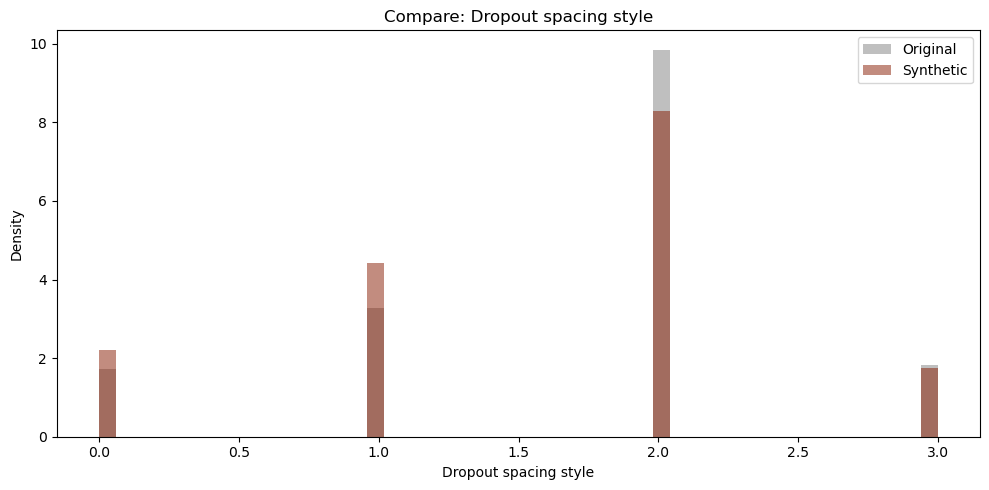

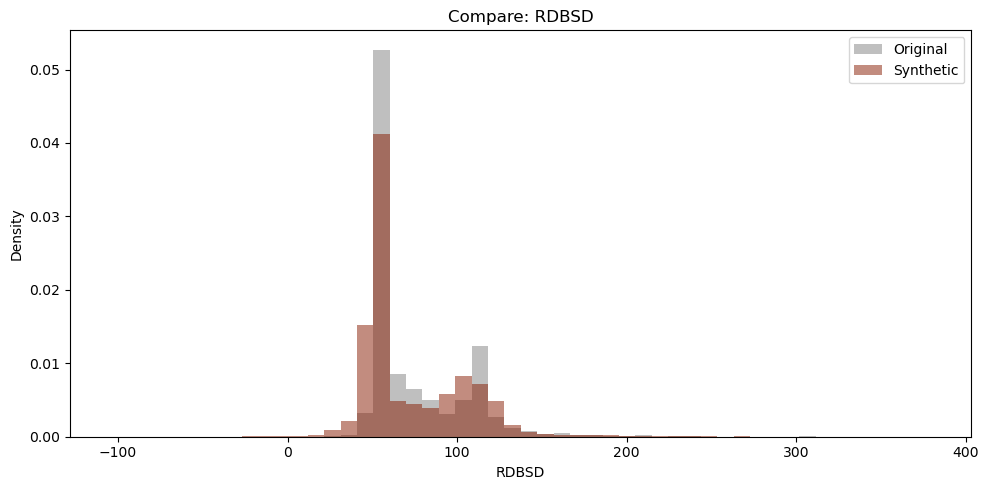

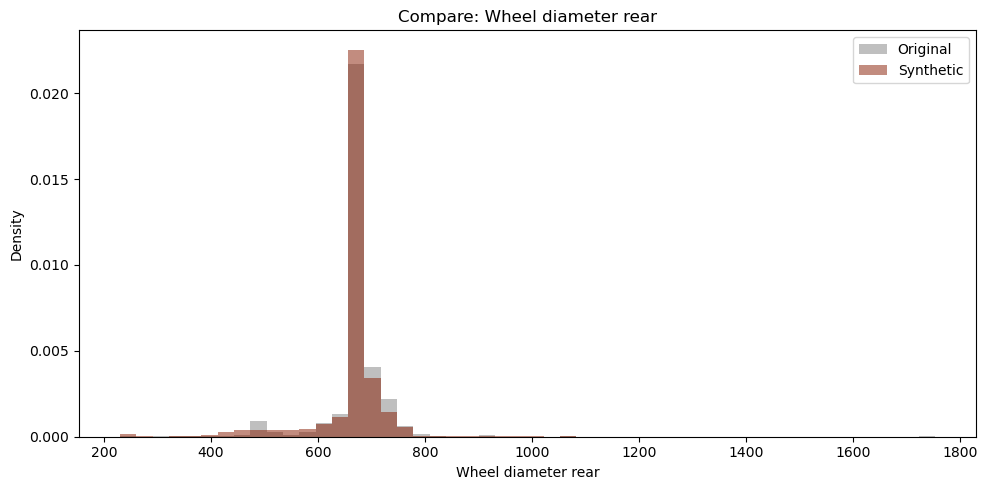

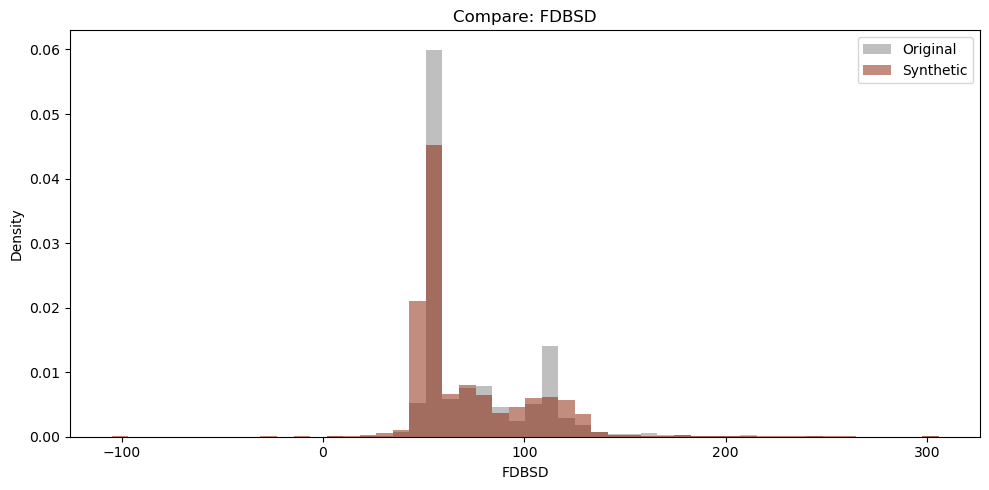

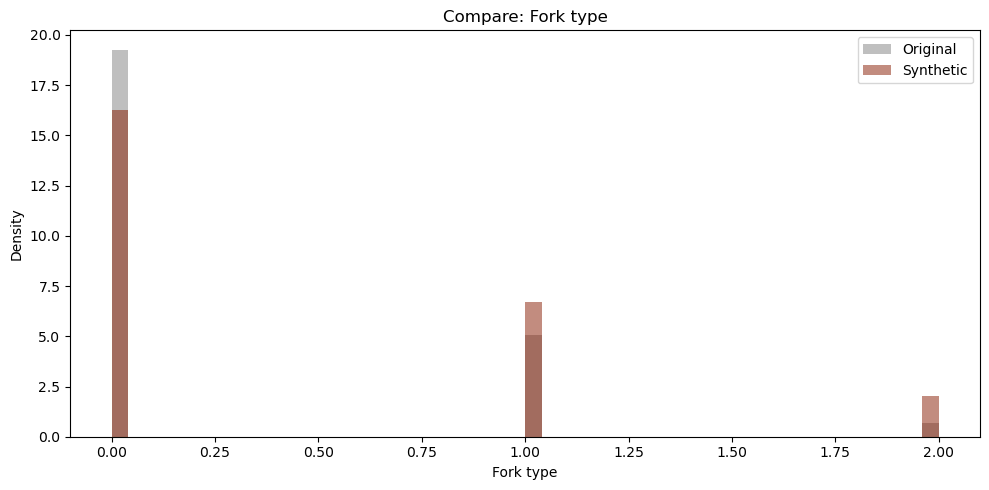

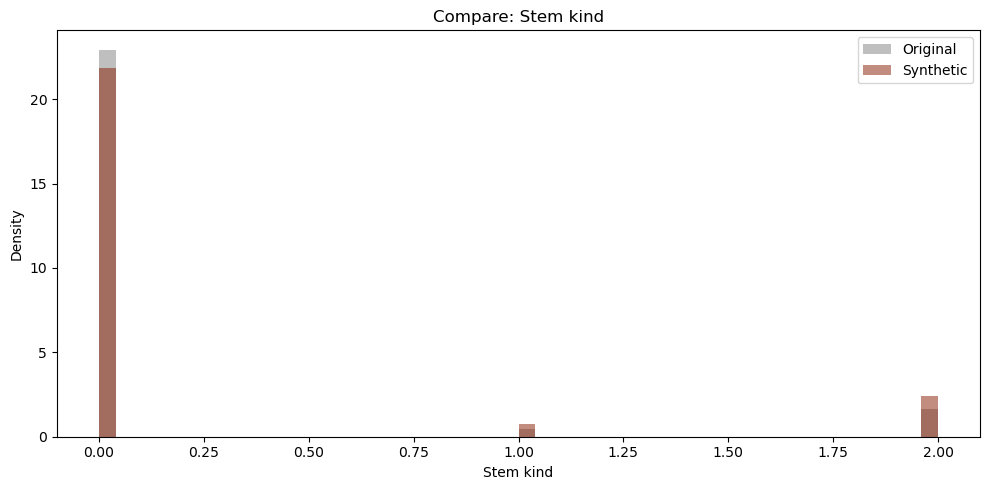

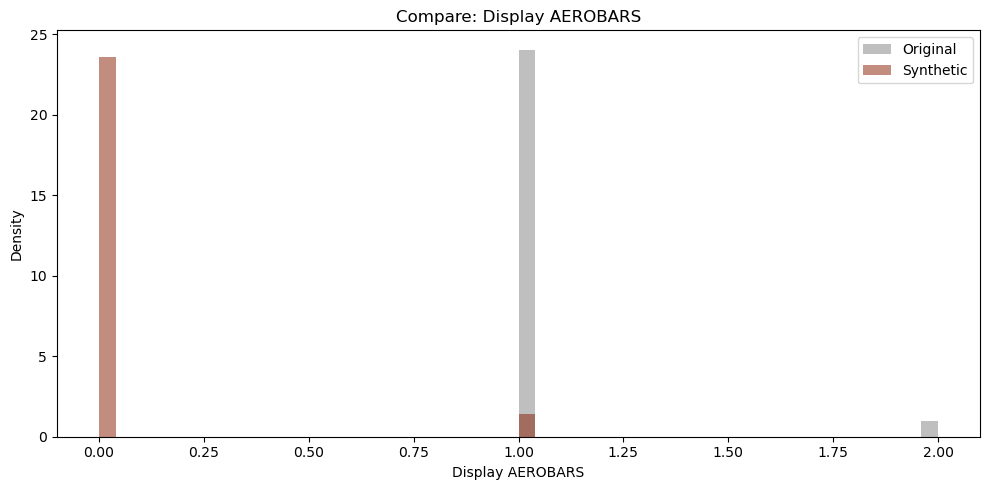

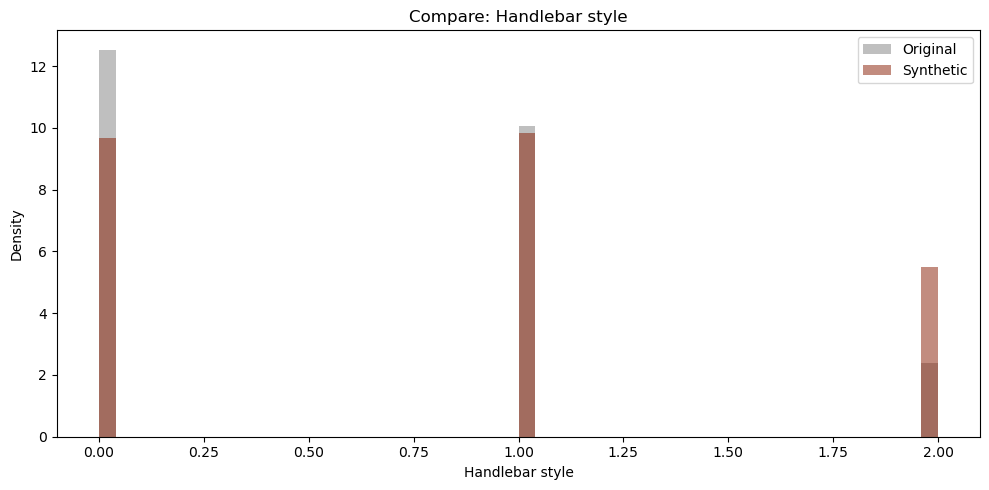

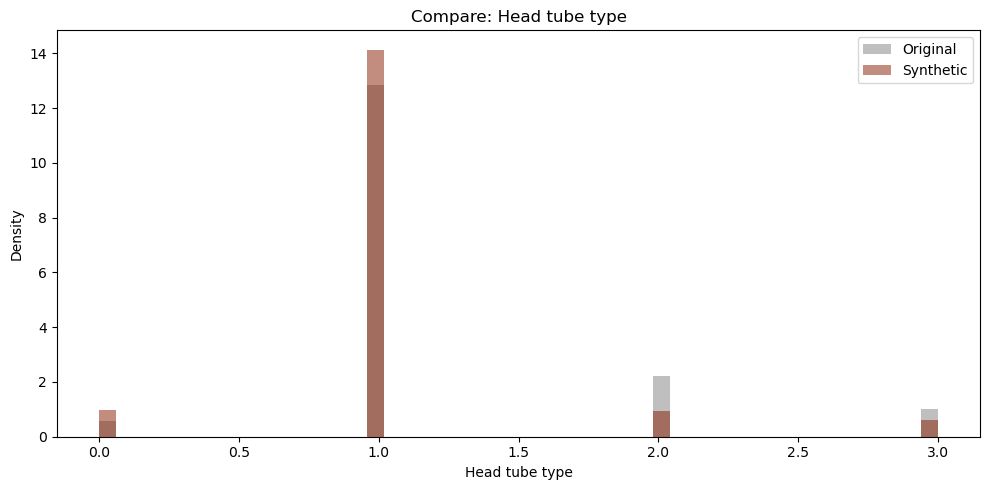

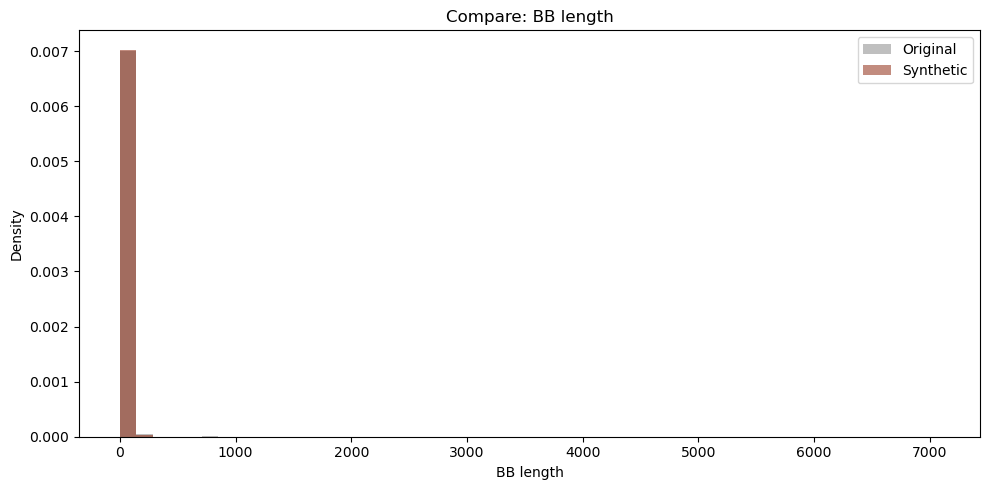

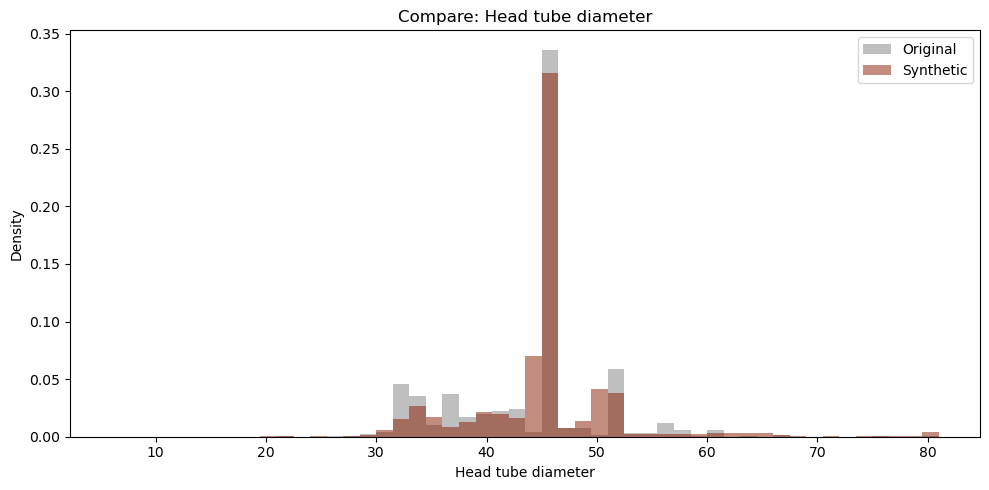

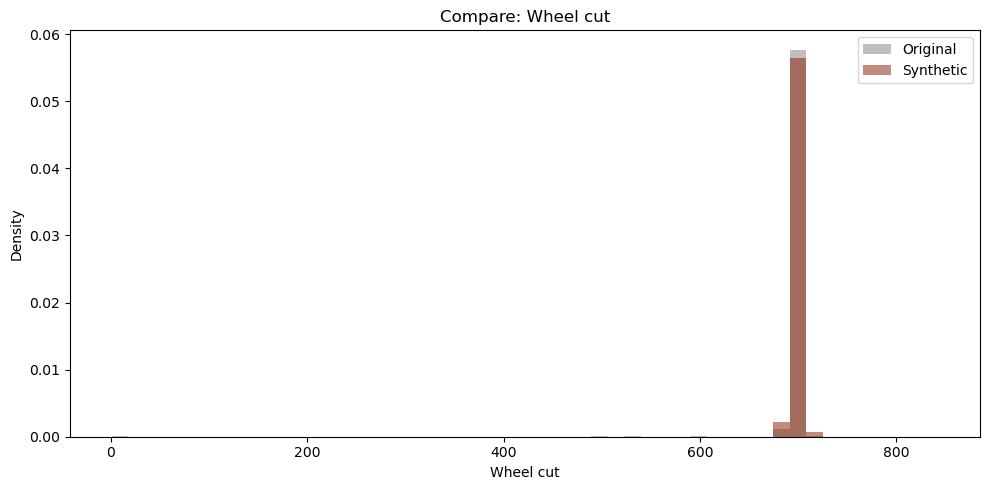

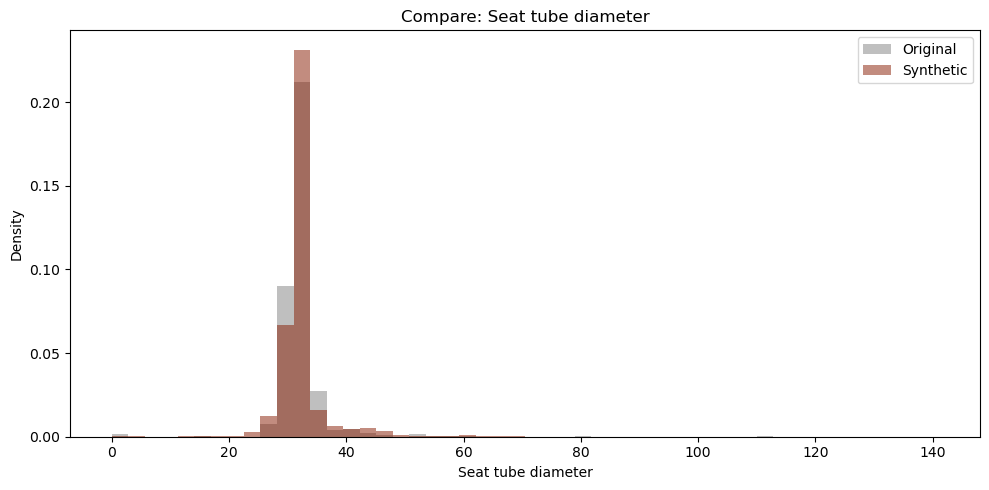

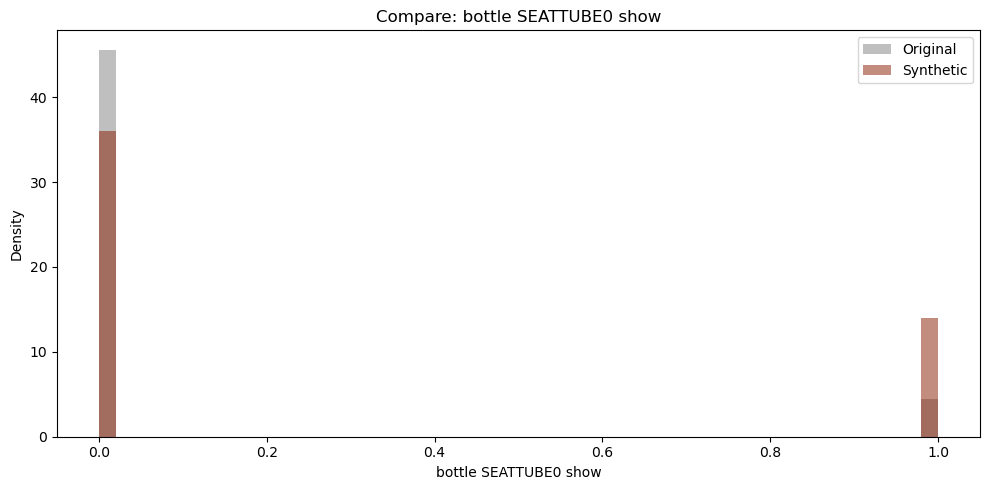

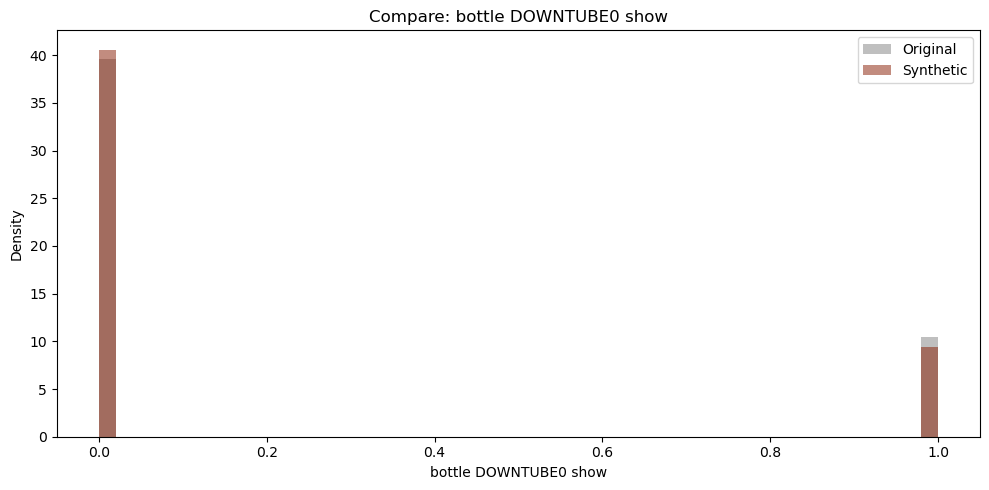

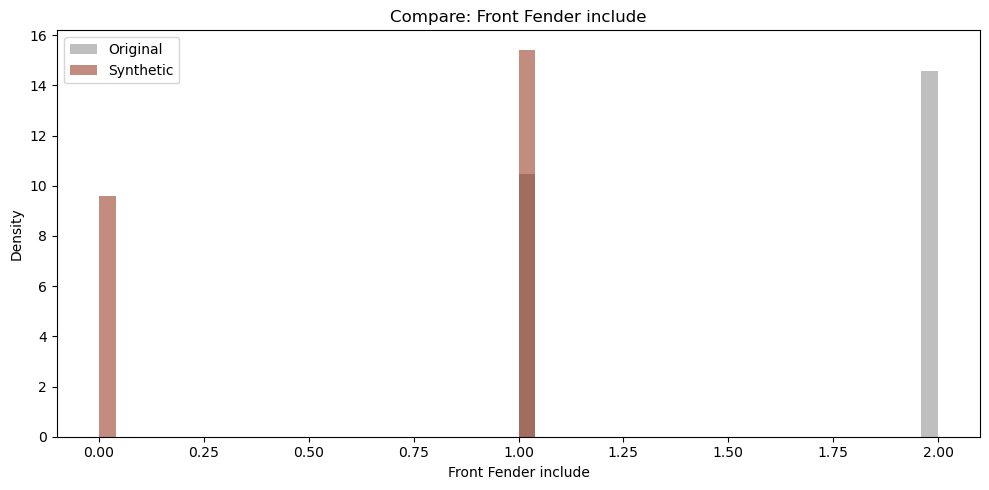

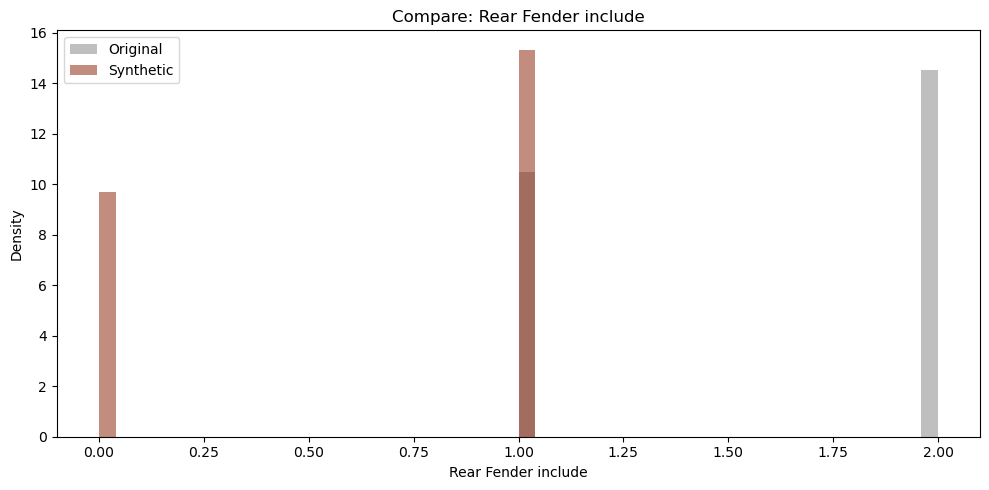

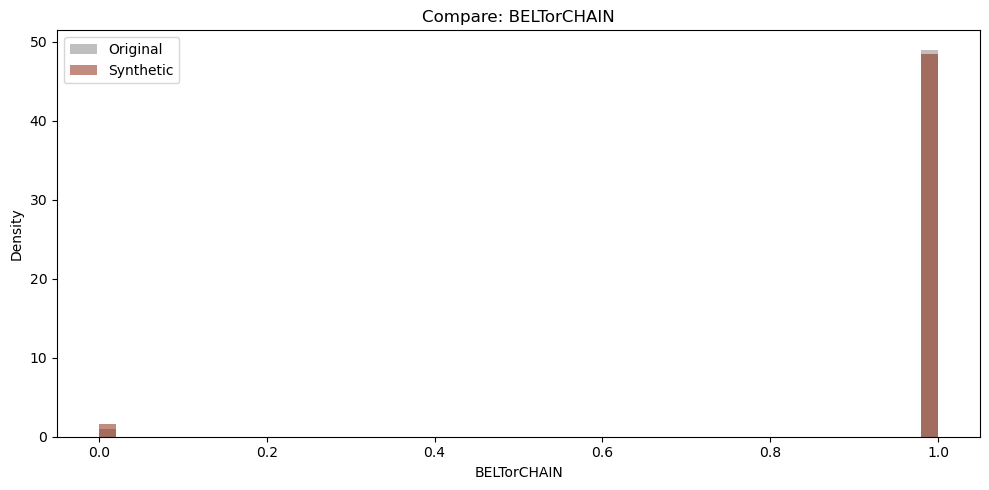

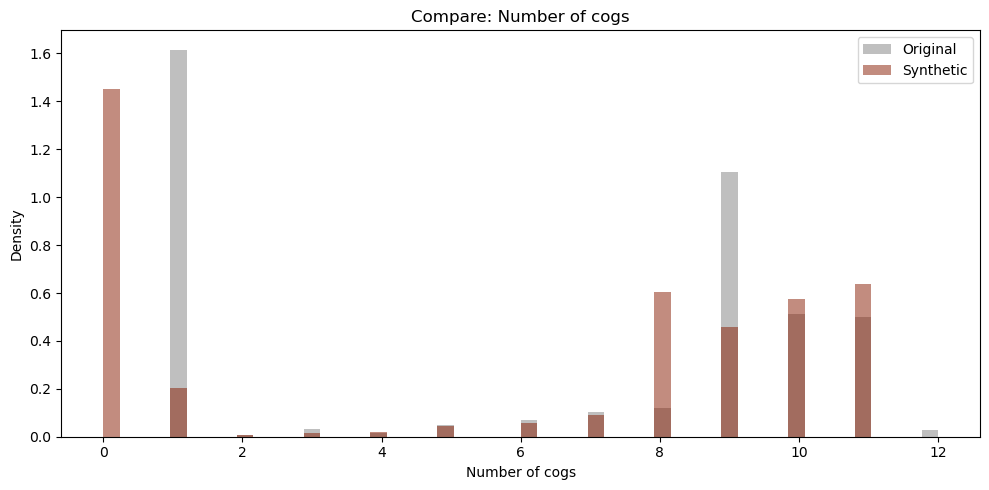

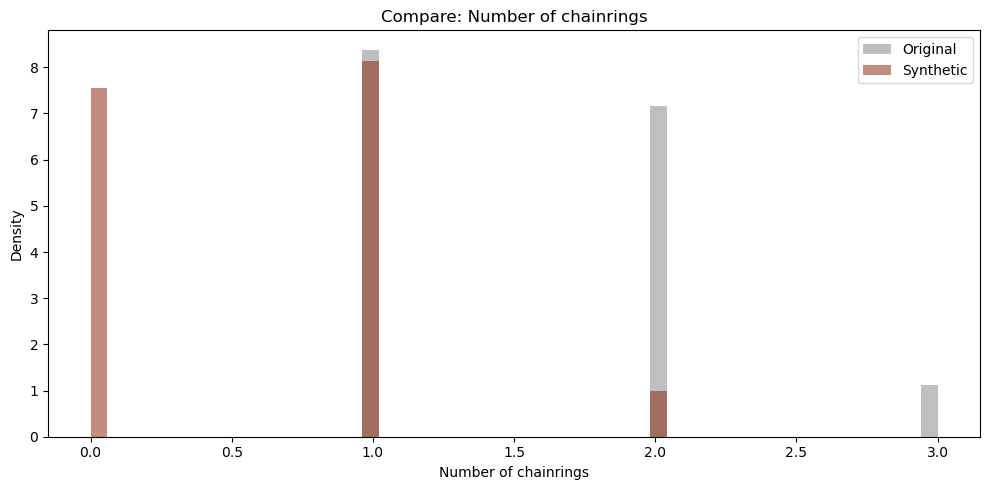

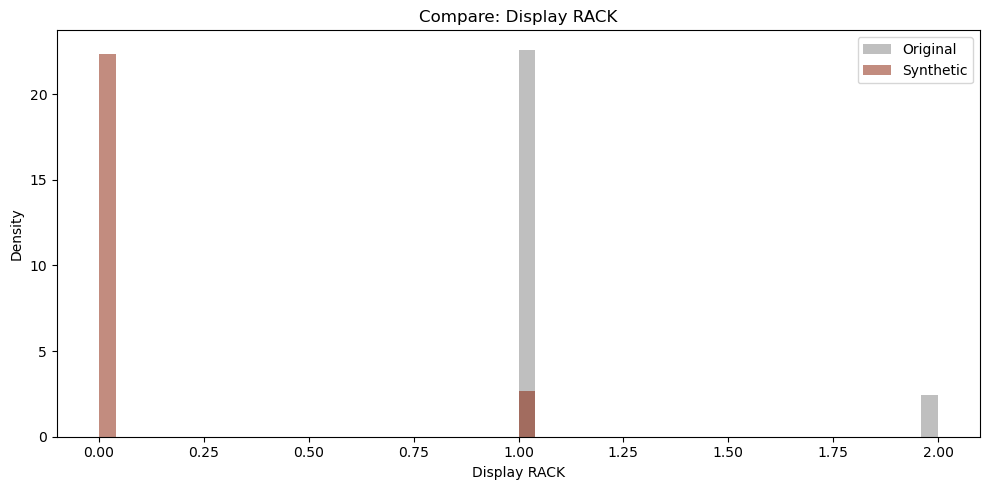

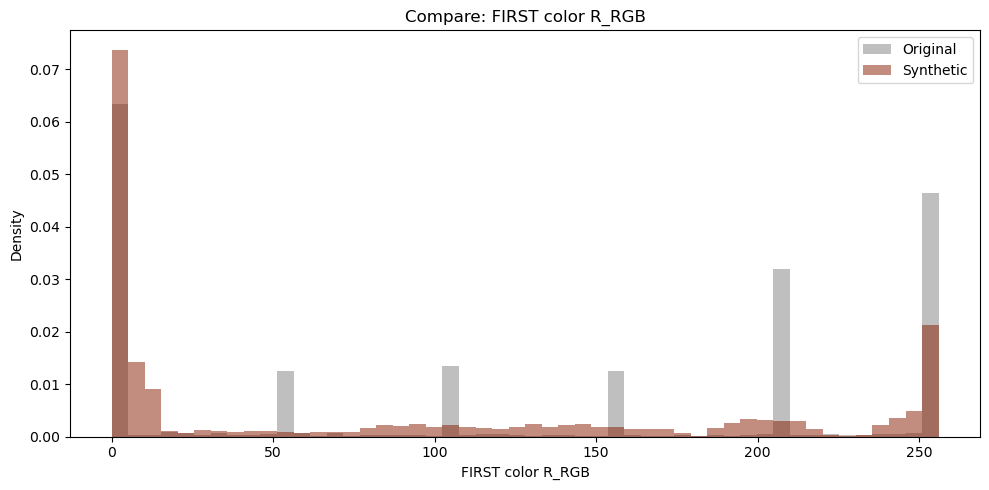

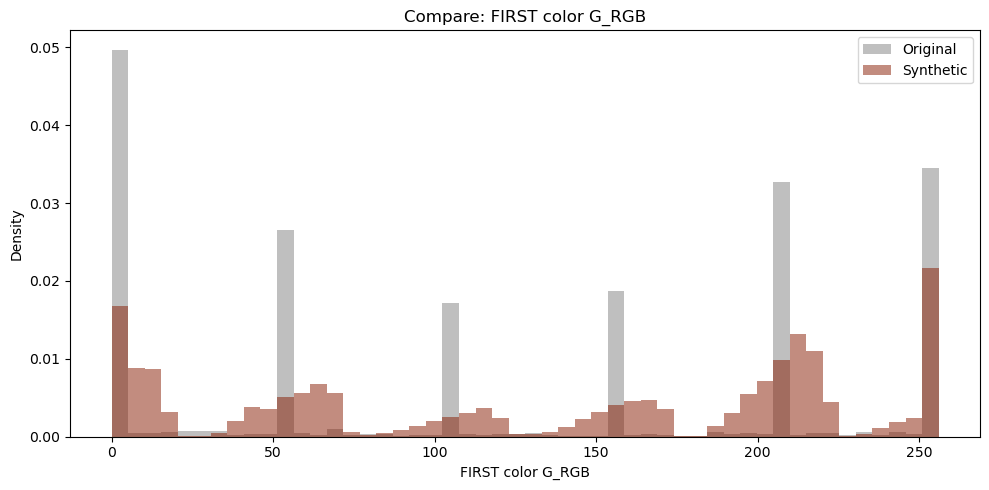

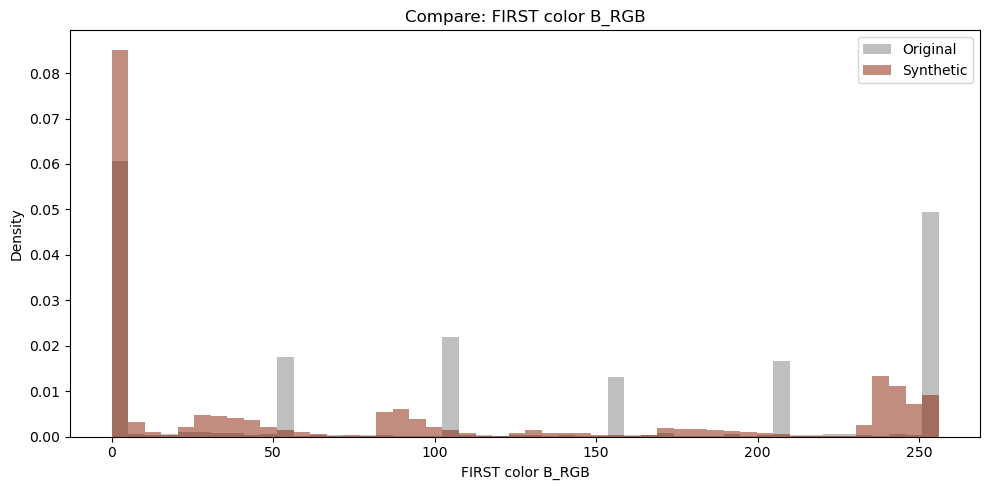

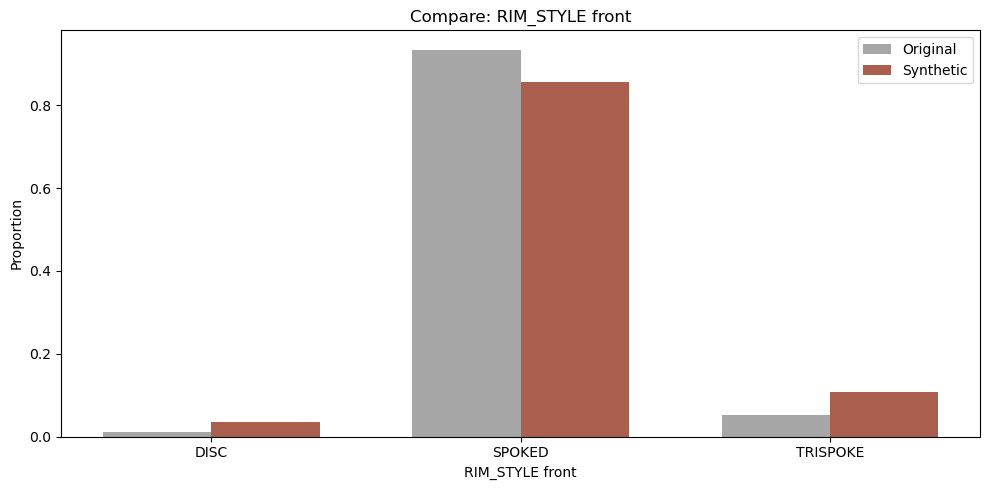

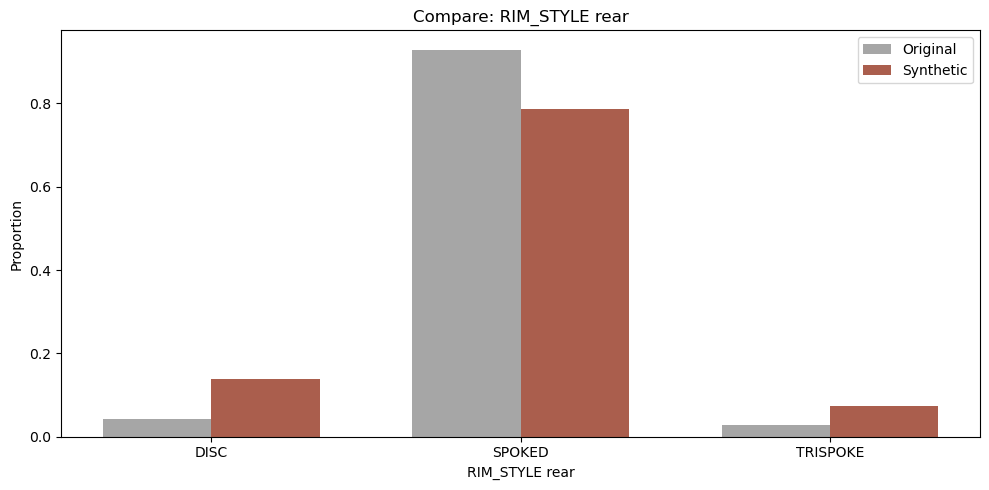

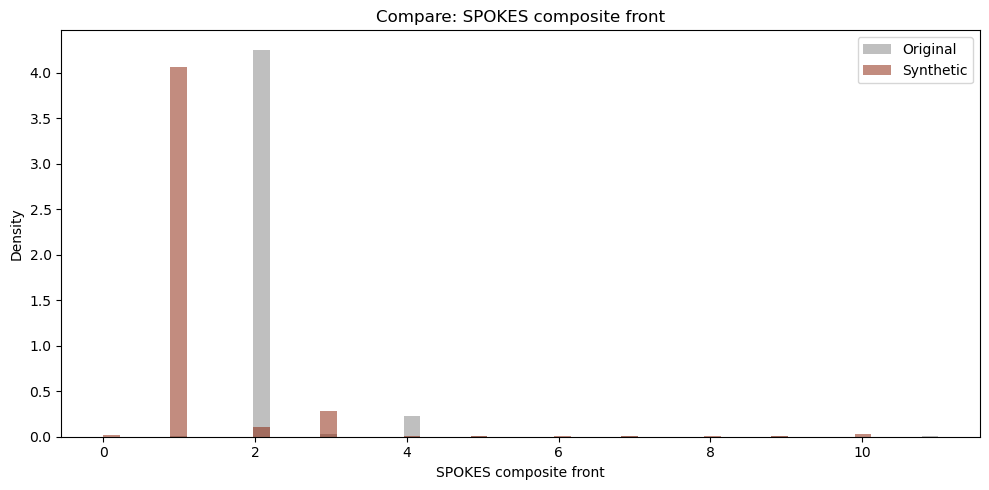

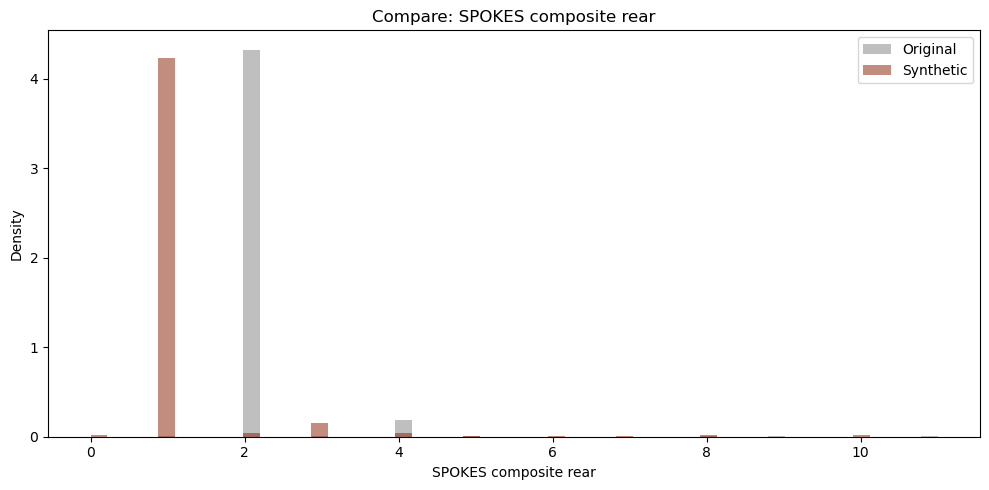

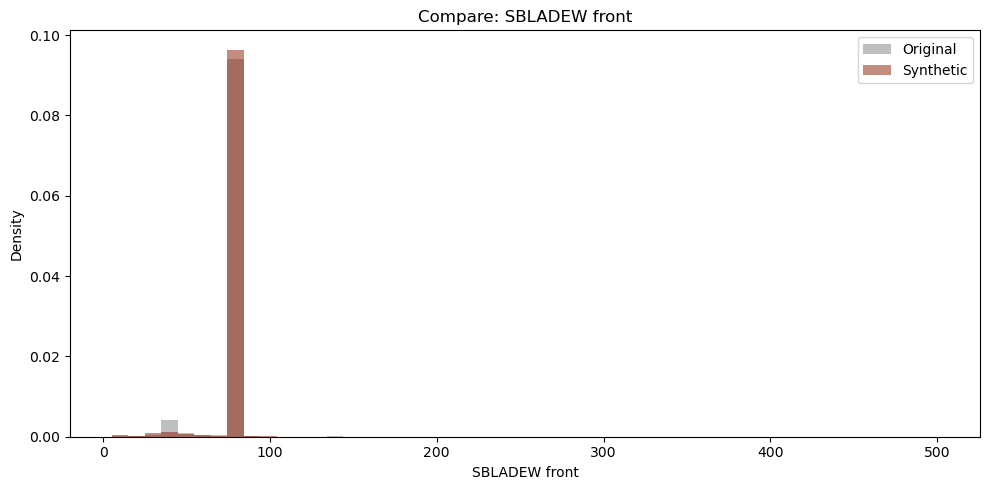

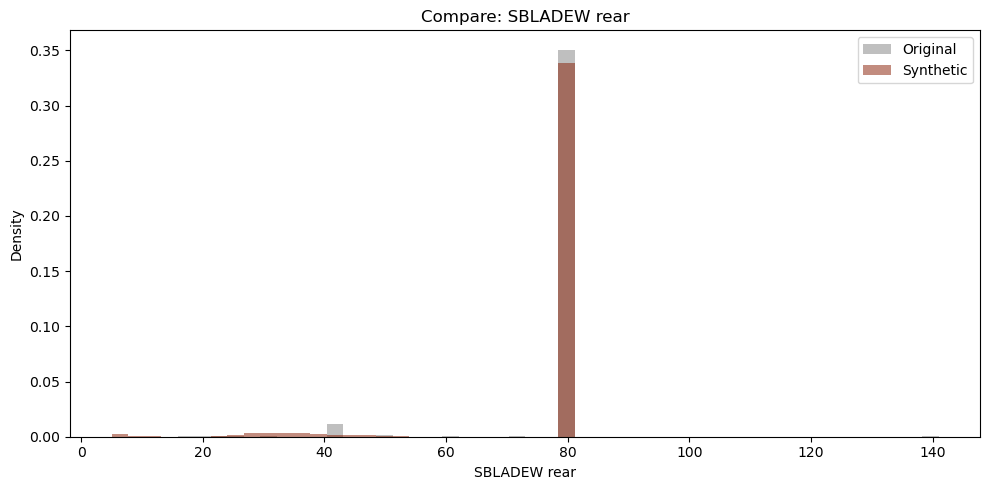

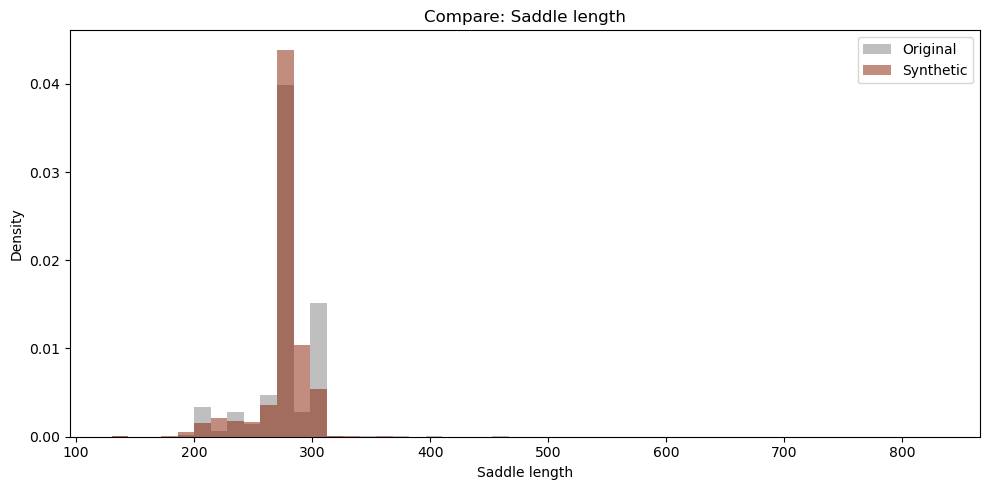

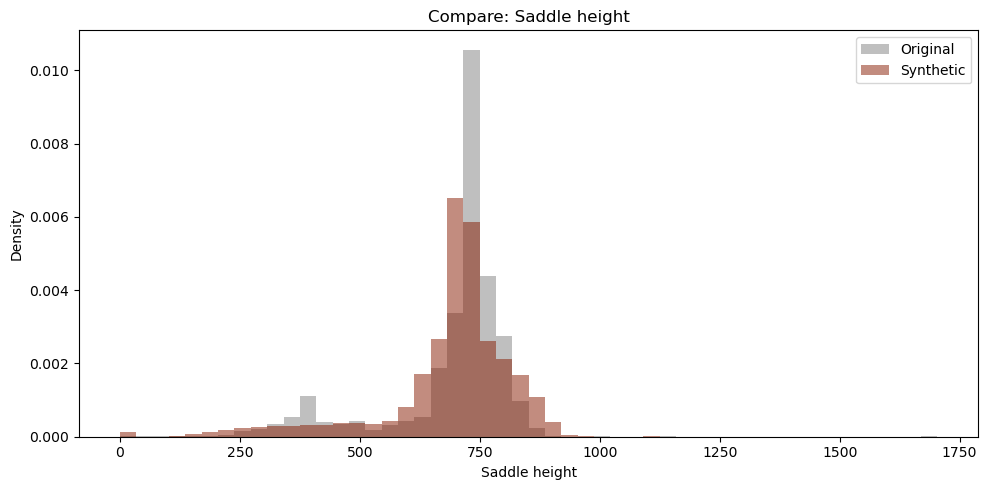

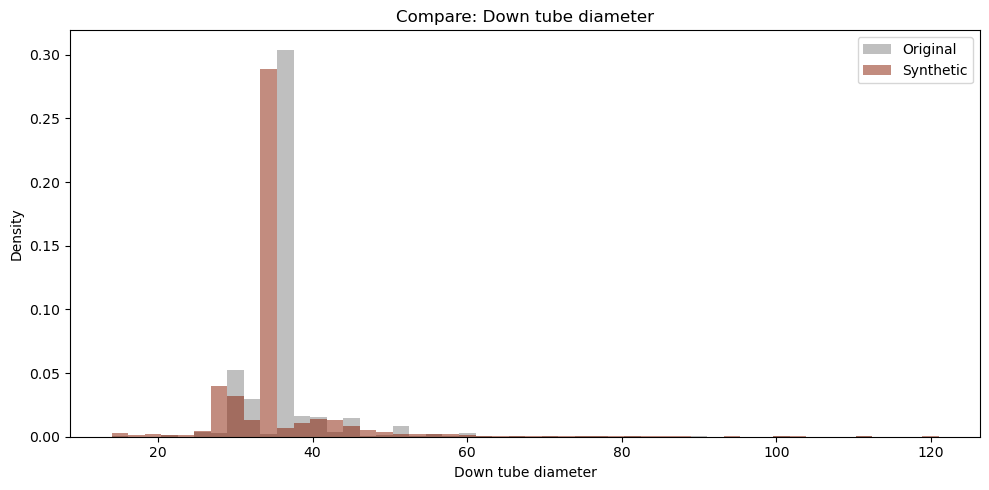

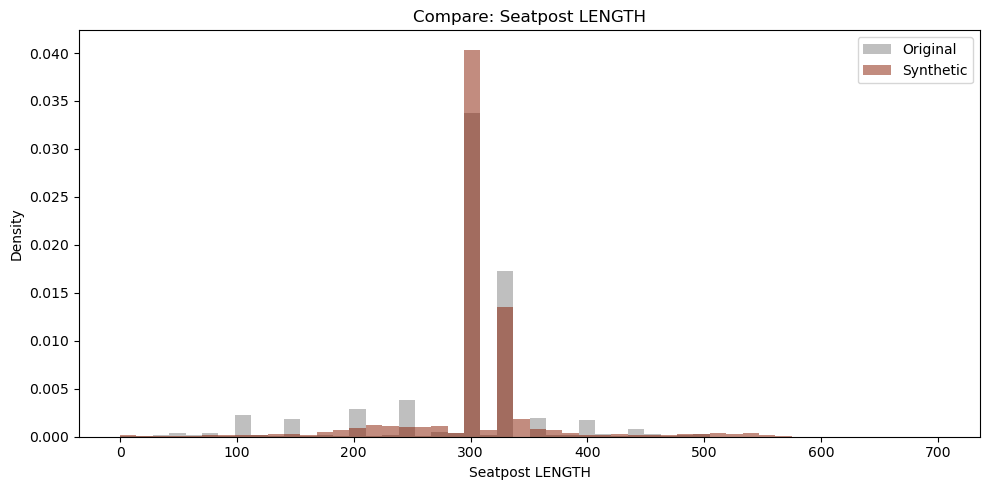

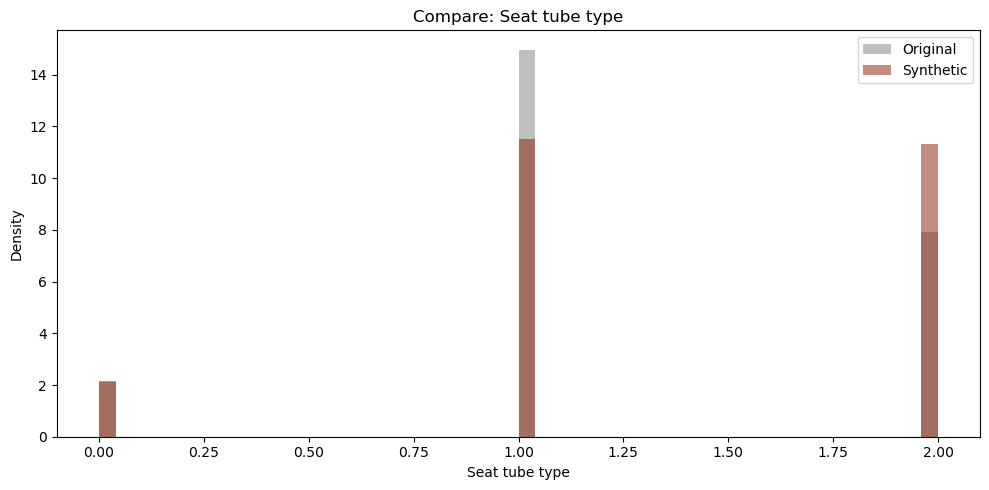

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compare_distributions(
    real_df: pd.DataFrame,
    synth_df: pd.DataFrame,
    numeric_bins: int = 50,
    figsize: tuple = (10, 5)
):
    """
    For each column in real_df / synth_df:
      - Numeric: overlaid, fixed‐width histograms
      - Categorical/boolean: side‐by‐side bar plots with equal bar width
    """
    orig_color = 'gray'
    synth_color = '#871a01'
    for col in real_df.columns:
        plt.figure(figsize=figsize)
        real = real_df[col]
        synth = synth_df[col]

        # --- Numeric / ordinal columns ---
        if pd.api.types.is_numeric_dtype(real):
            # convert to numpy arrays
            r = real.dropna().to_numpy()
            s = synth.dropna().to_numpy()

            # common min/max & bins
            lo, hi = np.min([r.min(), s.min()]), np.max([r.max(), s.max()])
            bins = np.linspace(lo, hi, numeric_bins + 1)

            plt.hist(r, bins=bins, density=True, alpha=0.5, label='Original', color = orig_color)
            plt.hist(s, bins=bins, density=True, alpha=0.5, label='Synthetic', color = synth_color)
            plt.xlabel(col)
            plt.ylabel('Density')

        # --- Categorical or boolean columns ---
        else:
            # get normalized counts
            real_counts  = real.value_counts(normalize=True)
            synth_counts = synth.value_counts(normalize=True)

            # union of all categories / levels
            levels = sorted(set(real_counts.index) | set(synth_counts.index))

            # proportions in that order
            real_props  = [real_counts .get(l, 0) for l in levels]
            synth_props = [synth_counts.get(l, 0) for l in levels]

            # integer x positions & fixed bar width
            x = np.arange(len(levels))
            width = 0.35

            plt.bar(x - width/2, real_props,  width, label='Original', color=orig_color, alpha=0.7)
            plt.bar(x + width/2, synth_props, width, label='Synthetic', color=synth_color, alpha=0.7)

            # label ticks with the actual level names
            plt.xticks(x, [str(l) for l in levels])
            plt.xlabel(col)
            plt.ylabel('Proportion')

        plt.title(f'Compare: {col}')
        plt.legend()
        plt.tight_layout()
        plt.show()

compare_distributions(data, synthetic_collapsed, numeric_bins=50, figsize=(10, 5))

In [14]:
from biked_commons.transformation.one_hot_encoding import encode_to_continuous
samples_oh = encode_to_continuous(synthetic_collapsed)

In [15]:
samples_oh

,CS textfield,BB textfield,Stack,Head angle,Head tube length textfield,Seat stay junction0,Seat tube length,Seat angle,DT Length,FORK0R,...,Handlebar style OHCLASS: 2,Stem kind OHCLASS: 0,Stem kind OHCLASS: 1,Stem kind OHCLASS: 2,Fork type OHCLASS: 0,Fork type OHCLASS: 1,Fork type OHCLASS: 2,Seat tube type OHCLASS: 0,Seat tube type OHCLASS: 1,Seat tube type OHCLASS: 2
0,387.868683,67.139145,636.039795,73.719475,169.375427,40.759998,520.390015,73.589455,614.949524,12.780000,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.000000,36.841888,533.960632,73.751732,158.450531,29.650000,363.480011,70.263939,518.417236,44.770000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,396.297119,74.881104,591.839111,79.160225,179.486923,46.360001,546.859985,77.064156,678.659241,30.650000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,346.308258,44.050079,573.518738,75.751160,159.515366,45.610001,503.579987,80.797104,774.538391,44.110001,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,418.116791,73.365799,584.617676,69.181038,147.891388,44.669998,465.640015,73.522537,668.054993,30.930000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,332.935822,9.565175,611.556763,75.316521,164.304947,-6.030000,509.230011,76.118942,656.147217,37.560001,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9996,391.923615,72.974792,633.806458,74.763573,132.674774,48.689999,622.859985,76.075310,670.655457,54.480000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
9997,393.336090,72.858910,669.676575,76.301933,235.291595,41.660000,633.859985,74.807785,623.411011,54.009998,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9998,395.956146,71.743668,618.715393,73.285896,239.132690,91.010002,576.039978,75.286720,598.834778,45.740002,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
from biked_commons.api import rendering
renderer = rendering.RenderingEngine(number_rendering_servers = 1, server_init_timeout_seconds=120)



Using java as the Java binary


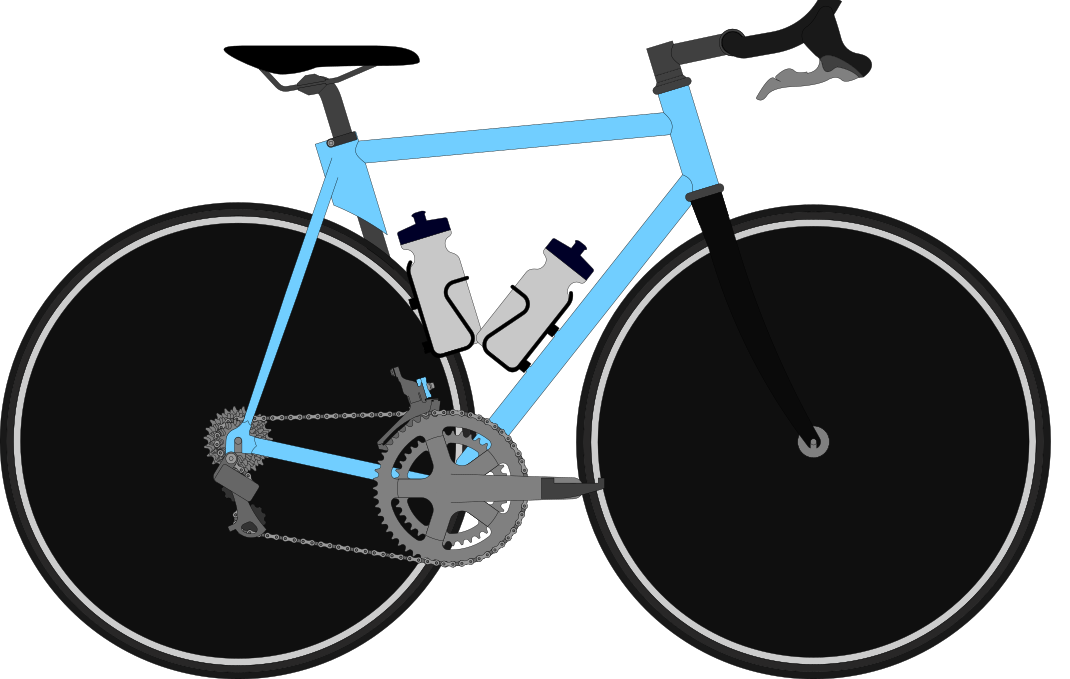

In [42]:
data1 = samples_oh.iloc[0]
res = renderer.render_clip(data1)
svg = res.image_bytes
from IPython.display import SVG, display
display(SVG(svg))

In [13]:
from biked_commons.validation.base_validation_function import construct_tensor_validator, construct_dataframe_validator

def sample_n(n=4096):
    save_path = models_and_scalers_path("CTGAN.pkl")
    synthesizer = CTGANSynthesizer.load(filepath=save_path)
    sample_datapoint = synthesizer.sample(num_rows=1)
    sample_datapoint_oh = encode_to_continuous(sample_datapoint)
    COLUMN_NAMES = list(sample_datapoint_oh.columns)
    tensor_validator, validation_names = construct_tensor_validator(CLIPS_VALIDATIONS, COLUMN_NAMES)

    all_valid_samples = None
    while True:
        synthetic_collapsed = synthesizer.sample(num_rows=10000)
        samples_oh = encode_to_continuous(synthetic_collapsed)
        samples_oh_tens = torch.tensor(samples_oh.values, dtype=torch.float32)

        validity = tensor_validator(samples_oh_tens)

        valid = torch.all(validity<=0, dim=1)
        valid_subset = samples_oh_tens[valid, :]
        if all_valid_samples is None:
            all_valid_samples = valid_subset
        else:
            all_valid_samples = torch.cat((all_valid_samples, valid_subset), dim=0)
        if all_valid_samples.shape[0] >= n:
            break
    all_valid_samples = all_valid_samples[:n, :]
    samples_df = pd.DataFrame(all_valid_samples.numpy(), columns=COLUMN_NAMES)
    return samples_df

def sample_n_df(n=4096):
    data = sample_n(n)
    return data

df = sample_n_df(256)